<a href="https://colab.research.google.com/github/Anichitra30/Loan-Default-Risk-Analysis/blob/main/FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective: The purpose of the project is to estimate the risk of default of each loan at origination and identify the prominent predictors of the risk for personal loans.**

Importing Modules & Libraries

In [1]:
pip install polars --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 1.9.0
    Uninstalling polars-1.9.0:
      Successfully uninstalled polars-1.9.0


In [2]:
!pip install xgboost

In [3]:
pip install imbalanced-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import altair as alt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# **Data Exploration**

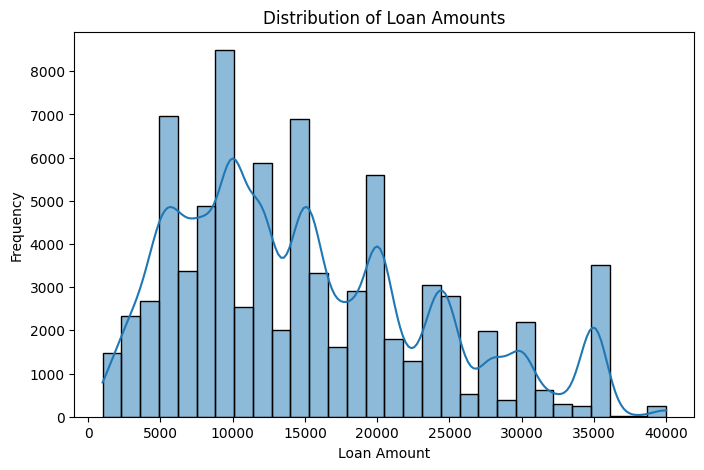

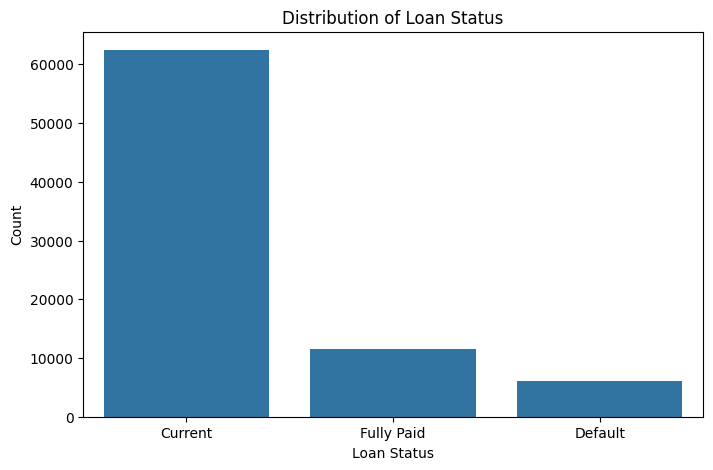

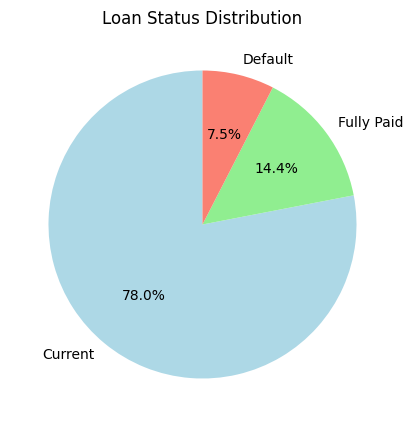

Summary Statistics for Numerical Features:
          loan_amnt   installment    annual_inc  fico_range_low  \
count  80000.000000  80000.000000  8.000000e+04    80000.000000   
mean   15055.793750    443.595158  7.778995e+04      694.314000   
std     8729.299624    255.693326  8.648673e+04       30.744603   
min     1000.000000     30.120000  0.000000e+00      660.000000   
25%     8000.000000    258.100000  4.700000e+04      670.000000   
50%    13275.000000    382.500000  6.500000e+04      685.000000   
75%    20000.000000    585.080000  9.250000e+04      710.000000   
max    40000.000000   1536.950000  8.706582e+06      845.000000   

       fico_range_high  
count     80000.000000  
mean        698.314112  
std          30.745156  
min         664.000000  
25%         674.000000  
50%         689.000000  
75%         714.000000  
max         850.000000  


(          loan_amnt   installment    annual_inc  fico_range_low  \
 count  80000.000000  80000.000000  8.000000e+04    80000.000000   
 mean   15055.793750    443.595158  7.778995e+04      694.314000   
 std     8729.299624    255.693326  8.648673e+04       30.744603   
 min     1000.000000     30.120000  0.000000e+00      660.000000   
 25%     8000.000000    258.100000  4.700000e+04      670.000000   
 50%    13275.000000    382.500000  6.500000e+04      685.000000   
 75%    20000.000000    585.080000  9.250000e+04      710.000000   
 max    40000.000000   1536.950000  8.706582e+06      845.000000   
 
        fico_range_high  
 count     80000.000000  
 mean        698.314112  
 std          30.745156  
 min         664.000000  
 25%         674.000000  
 50%         689.000000  
 75%         714.000000  
 max         850.000000  ,
 id                            0
 loan_amnt                     0
 term                          0
 installment                   0
 emp_length        

In [5]:
data_file = "https://github.com/Anichitra30/Loan-Default-Risk-Analysis/raw/main/Data/data.csv"
data_dictionary_file = "https://github.com/Anichitra30/Loan-Default-Risk-Analysis/raw/main/Data/data_dictionary.csv.xlsx"


data_df = pd.read_csv(data_file)

#Exploratory Data Analysis (EDA)
#Analyzing key features: loan_status, loan_amnt, term, installment, emp_length, and financial indicators

#1. Summary statistics for numerical features
numerical_features = ['loan_amnt', 'installment', 'annual_inc', 'fico_range_low', 'fico_range_high']
summary_stats = data_df[numerical_features].describe()

#2. Distribution of loan amounts
plt.figure(figsize=(8, 5))
sns.histplot(data_df['loan_amnt'], kde=True, bins=30)
plt.title("Distribution of Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()

# 3. Count of loan statuses
plt.figure(figsize=(8, 5))
sns.countplot(data=data_df, x='loan_status', order=data_df['loan_status'].value_counts().index)
plt.title("Distribution of Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

#Data Cleaning
#Checking for missing values
missing_values = data_df.isnull().sum()

# Filling missing values where applicable (e.g., imputing or handling missing financial indicators)
#dropping critical rows with missing 'loan_amnt', 'installment', 'annual_inc'
data_cleaned = data_df.dropna(subset=['loan_amnt', 'installment', 'annual_inc'])

#Feature Engineering
#Transforming 'emp_length' from strings to numerical values
def emp_length_to_num(emp_length):
    if pd.isna(emp_length):
        return None
    elif emp_length == '10+ years':
        return 10
    elif emp_length == '< 1 year':
        return 0
    else:
        return int(emp_length.split()[0])

data_cleaned['emp_length_num'] = data_cleaned['emp_length'].apply(emp_length_to_num)

#Data Distribution
#Visualizing the balance of loan_status categories for understanding
loan_status_counts = data_cleaned['loan_status'].value_counts()

plt.figure(figsize=(8, 5))
loan_status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'salmon'])
plt.title("Loan Status Distribution")
plt.ylabel("")
plt.show()

#results for initial insights
print("Summary Statistics for Numerical Features:")
print(summary_stats)

summary_stats, missing_values, loan_status_counts


Further EDA using Polars DataFrame

> This is just another way of showing the analysis. Polars dataframe are less used but have more to offer.



In [6]:
data = pl.read_csv(data_file)

#Summary statistics
summary_stats = data.describe()

#filter rows where loan_amnt > 15000)
high_loan_amnt = data.filter(pl.col("loan_amnt") > 15000)

#Aggregation-calculating average loan_amnt by loan_status
avg_loan_amnt_by_status = data.group_by("loan_status").agg(
    pl.col("loan_amnt").mean().alias("avg_loan_amnt")
)

#conditional aggregation with filtering)
high_income_avg = data.filter(pl.col("annual_inc") > 50000).group_by("loan_status").agg(
    pl.col("loan_amnt").mean().alias("avg_high_income_loan_amnt")
)

print("Summary Statistics:\n", summary_stats)
print("High Loan Amounts:\n", high_loan_amnt)
print("Average Loan Amount by Status:\n", avg_loan_amnt_by_status)
print("Average Loan Amount for High-Income Applicants by Status:\n", high_income_avg)


Summary Statistics:
 shape: (9, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ id        ┆ loan_amnt ┆ term      ┆ … ┆ mths_sinc ┆ mths_sinc ┆ inq_last_ ┆ inq_last │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ e_last_de ┆ e_last_re ┆ 6mths     ┆ _12m     │
│ str       ┆ f64       ┆ f64       ┆ str       ┆   ┆ linq      ┆ cord      ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ f64       ┆ str      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 80000.0   ┆ 80000.0   ┆ 80000     ┆ … ┆ 80000     ┆ 80000     ┆ 80000.0   ┆ 80000    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0.0       ┆ 0        │
│ t         ┆           ┆           ┆           ┆   ┆  

**EDA: Adding New Features**
- Income-to-Loan Ratio
- Debt-to-Income Ratio (DTI) Enhancement
- Credit Score Category
- Employment Length Category
- Loan Term to Income Ratio
- Monthly Payment to Income Ratio
- Interaction Terms
- Past Delinquencies Indicator

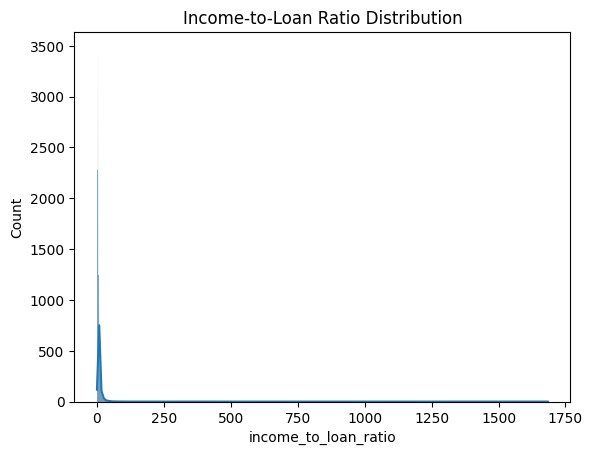

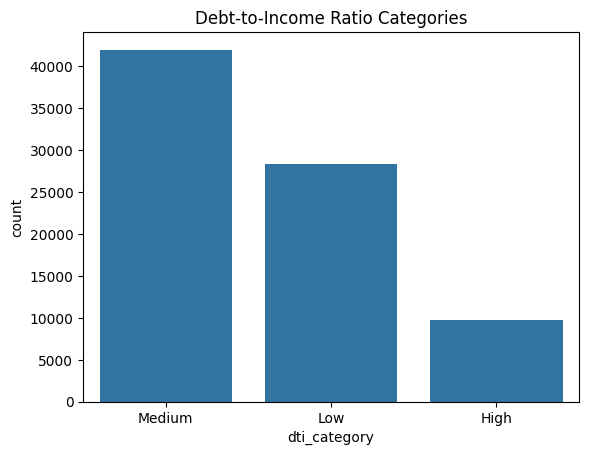

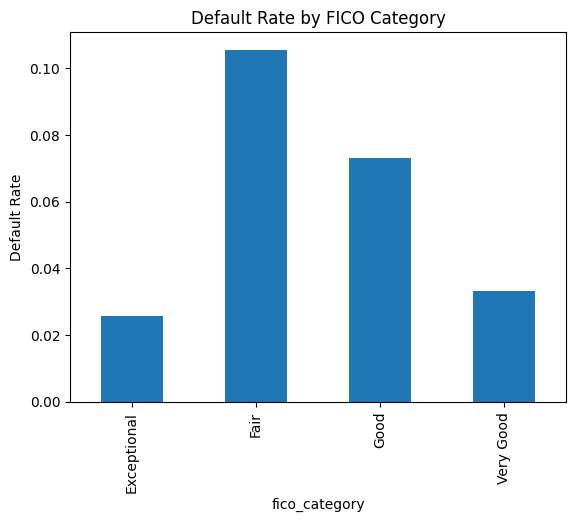

In [7]:
data = pl.read_csv(data_file)

#creating 'emp_length_num' if missing
if "emp_length_num" not in data.columns:
    def parse_emp_length(emp_length):
        if emp_length == '10+ years':
            return 10
        elif emp_length == '< 1 year':
            return 0
        elif isinstance(emp_length, str):
            return int(emp_length.split()[0])  # Extract number of years
        else:
            return None

    data = data.with_columns(
        pl.col("emp_length").map_elements(parse_emp_length, return_dtype=pl.Int64).alias("emp_length_num")
    )

#Income-to-Loan Ratio
data = data.with_columns([(pl.col("annual_inc") / pl.col("loan_amnt")).alias("income_to_loan_ratio")])

#Debt-to-Income (DTI) Category
data = data.with_columns([
    pl.when(pl.col("dti") <= 15).then(pl.lit("Low"))
    .when(pl.col("dti") <= 30).then(pl.lit("Medium"))
    .otherwise(pl.lit("High")).alias("dti_category")
])

#Credit Score Category
def categorize_fico(fico_score):
    if fico_score < 580:
        return 'Poor'
    elif fico_score < 670:
        return 'Fair'
    elif fico_score < 740:
        return 'Good'
    elif fico_score < 800:
        return 'Very Good'
    else:
        return 'Exceptional'

data = data.with_columns(
    pl.col("fico_range_low").map_elements(categorize_fico, return_dtype=pl.Utf8).alias("fico_category")
)

#Employment Length Category
data = data.with_columns([
    pl.when(pl.col("emp_length_num") <= 1).then(pl.lit("High Risk"))
    .when(pl.col("emp_length_num") <= 5).then(pl.lit("Medium Risk"))
    .otherwise(pl.lit("Low Risk")).alias("emp_length_category")
])

#Converting `term` to an integer by extracting numbers and dividing by income

data = data.with_columns([pl.col("term").str.extract(r"(\d+)").cast(pl.Int64).alias("term_numeric")]) #removing non-numeric characters,cast to Int64

#Loan Term to Income Ratio
data = data.with_columns([((pl.col("term_numeric") / 12) / pl.col("annual_inc")).alias("term_to_income_ratio")])

#Monthly Payment to Income Ratio
data = data.with_columns([(pl.col("installment") / (pl.col("annual_inc") / 12)).alias("monthly_payment_to_income_ratio")])

#Interaction Term (FICO Score × Income-to-Loan Ratio)
data = data.with_columns((pl.col("fico_range_low") * pl.col("income_to_loan_ratio")).alias("fico_income_interaction"))

#Past Delinquencies Indicator
data = data.with_columns(pl.when(pl.col("delinq_2yrs") > 0).then(1).otherwise(0).alias("has_past_delinquencies"))

#Convert to pandas for visualizations
data_pandas = data.to_pandas()

#Plot1 Income-to-Loan Ratio Distribution
sns.histplot(data_pandas['income_to_loan_ratio'], kde=True)
plt.title("Income-to-Loan Ratio Distribution")
plt.show()

#Plot DTI Categories
sns.countplot(data=data_pandas, x='dti_category')
plt.title("Debt-to-Income Ratio Categories")
plt.show()

#Analyzing impact of FICO Categories on Default Rate
if 'loan_status' in data_pandas.columns:
    fico_default_rate = data_pandas.groupby('fico_category')['loan_status'].value_counts(normalize=True).unstack()['Default']
    fico_default_rate.plot(kind='bar')
    plt.title("Default Rate by FICO Category")
    plt.ylabel("Default Rate")
    plt.show()
else:
    print("Column 'loan_status' not found in data for FICO Default Rate analysis.")


**Further Exploration**
- Relationship between annual income and loan amount?
- Impact of Verification Status on Loan Amount
- bucketing for annual income: what range of income has how many employees who take loan?

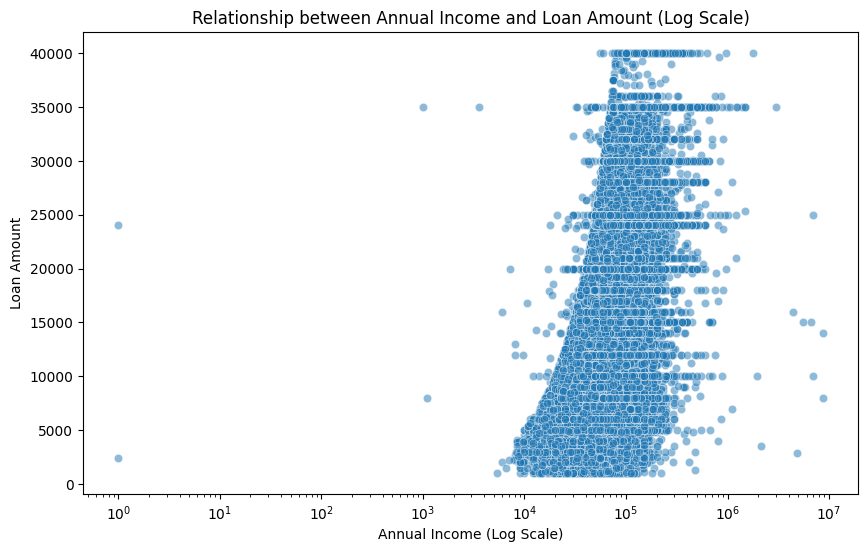

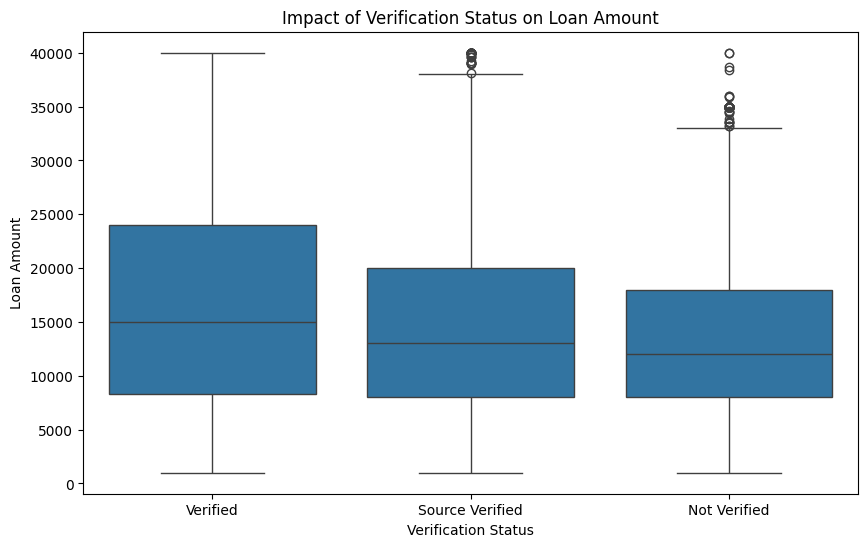

Income Bucket Table:
shape: (6, 2)
┌───────────────┬─────────────────────┐
│ Income Bucket ┆ Number of Borrowers │
│ ---           ┆ ---                 │
│ cat           ┆ i64                 │
╞═══════════════╪═════════════════════╡
│ 0-50K         ┆ 24989               │
│ 50K-100K      ┆ 39439               │
│ 100K-150K     ┆ 11135               │
│ 150K-200K     ┆ 2677                │
│ 200K-250K     ┆ 942                 │
│ 250K+         ┆ 817                 │
└───────────────┴─────────────────────┘


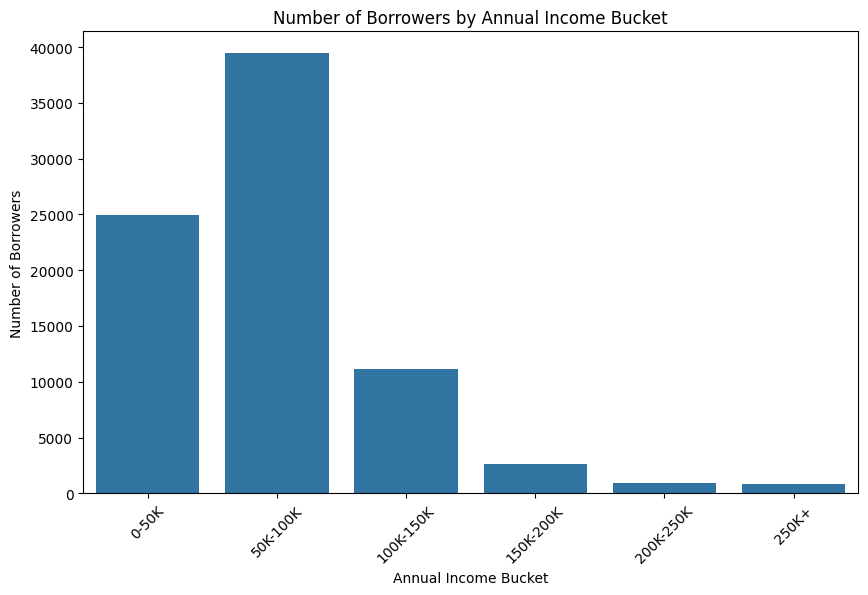

<ipython-input-8-52f1acb3dada>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default_rate = data_pandas.groupby('income_bucket')['loan_status'].apply(


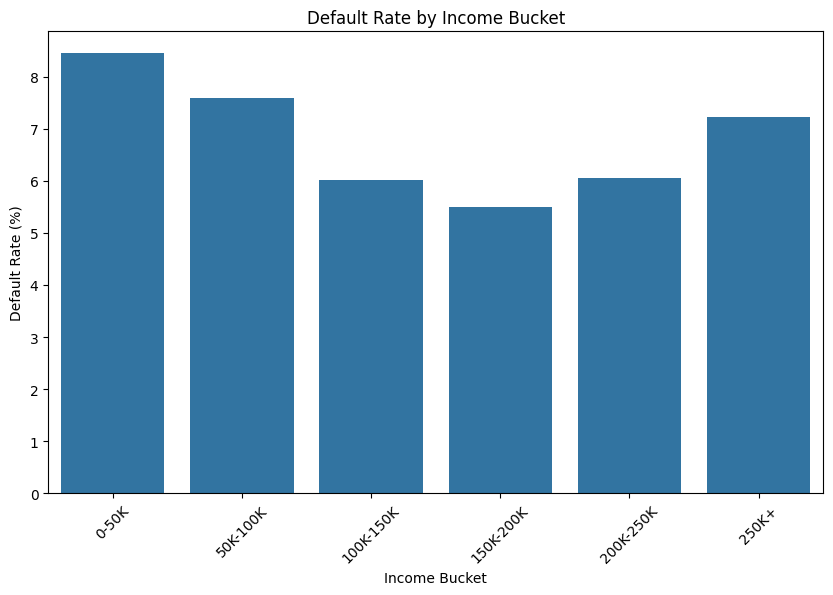

<ipython-input-8-52f1acb3dada>:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_loan_by_bucket = data_pandas.groupby('income_bucket')['loan_amnt'].mean().reset_index()


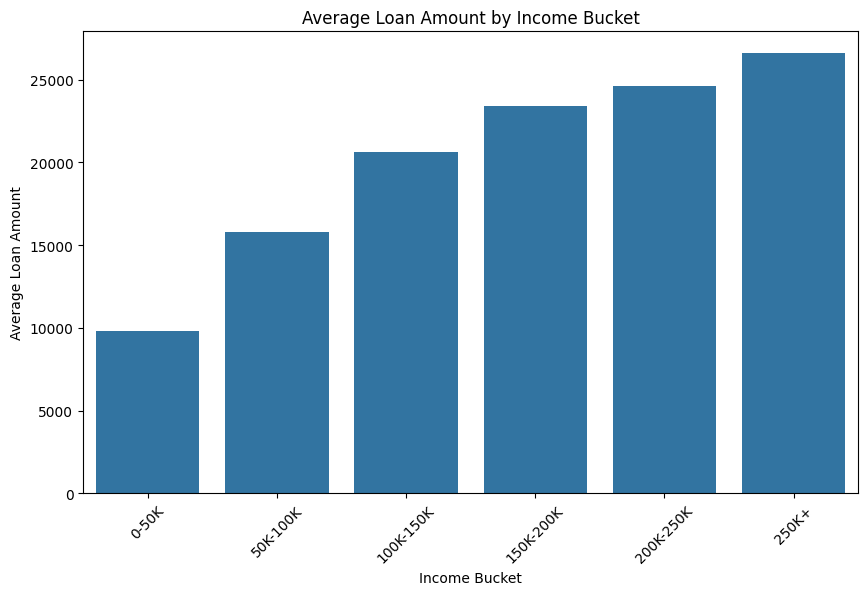

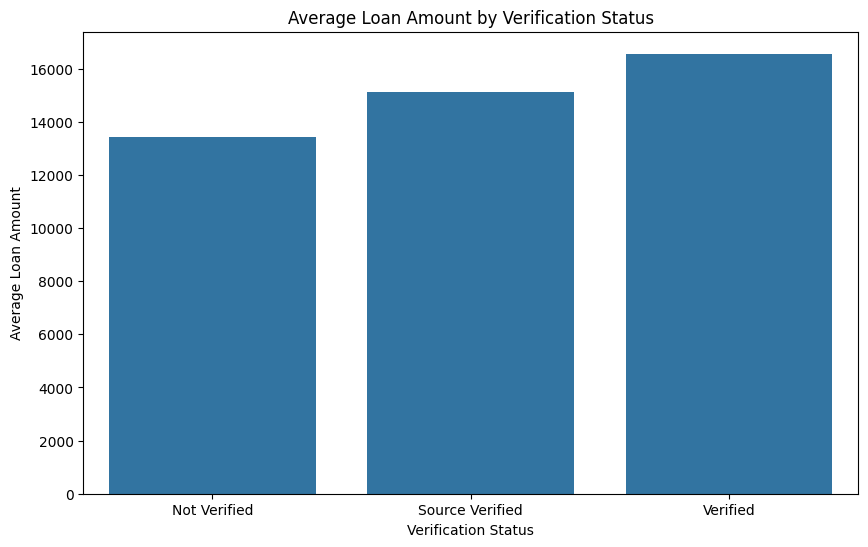


Summary of Analysis:
1. The scatter plot shows a clustering of low-income borrowers with a wide range of loan amounts.
2. Verified borrowers generally have higher loan amounts and fewer outliers.
3. Income buckets reveal that the majority of borrowers fall within the $50K-$100K range.
4. Default rates are highest in the $0-$50K bucket, suggesting higher risk for lower-income groups.
5. Loan amounts increase slightly with income, but higher-income borrowers are fewer in number.
6. Verification status influences loan amounts, highlighting the need for stronger risk assessment for unverified borrowers.


In [8]:
data_pandas = data.to_pandas()

#Step 1: Relationship between Annual Income and Loan Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_pandas, x='annual_inc', y='loan_amnt', alpha=0.5)
plt.xscale('log')  # Log scale for better visualization of income distribution
plt.title("Relationship between Annual Income and Loan Amount (Log Scale)")
plt.xlabel("Annual Income (Log Scale)")
plt.ylabel("Loan Amount")
plt.show()

#Step 2: Impact of Verification Status on Loan Amount
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_pandas, x='verification_status', y='loan_amnt')
plt.title("Impact of Verification Status on Loan Amount")
plt.xlabel("Verification Status")
plt.ylabel("Loan Amount")
plt.show()

#Step 3: Income Bucketing
#Quantile-based bucketing
quantile_bins = pd.qcut(data_pandas['annual_inc'], q=6, labels=["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"])
data_pandas['quantile_bucket'] = quantile_bins

#Fixed custom bins
custom_bins = [0, 50000, 100000, 150000, 200000, 250000, data_pandas['annual_inc'].max()]
custom_labels = ['0-50K', '50K-100K', '100K-150K', '150K-200K', '200K-250K', '250K+']
data_pandas['income_bucket'] = pd.cut(data_pandas['annual_inc'], bins=custom_bins, labels=custom_labels)

#Step 4: Income Bucket Table
bucket_table = data_pandas['income_bucket'].value_counts().reset_index()
bucket_table.columns = ['Income Bucket', 'Number of Borrowers']
bucket_table = bucket_table.sort_values(by='Income Bucket')

bucket_table_pl = pl.DataFrame(bucket_table)
print("Income Bucket Table:")
print(bucket_table_pl)

plt.figure(figsize=(10, 6))
sns.countplot(data=data_pandas, x='income_bucket', order=custom_labels)
plt.title("Number of Borrowers by Annual Income Bucket")
plt.xlabel("Annual Income Bucket")
plt.ylabel("Number of Borrowers")
plt.xticks(rotation=45)
plt.show()

#Step 5: Default Rate by Income Bucket
income_default_rate = data_pandas.groupby('income_bucket')['loan_status'].apply(
    lambda x: (x == 'Default').sum() / len(x) * 100
)
income_default_rate = income_default_rate.reset_index()
income_default_rate.columns = ['Income Bucket', 'Default Rate']

plt.figure(figsize=(10, 6))
sns.barplot(data=income_default_rate, x='Income Bucket', y='Default Rate', order=custom_labels)
plt.title("Default Rate by Income Bucket")
plt.xlabel("Income Bucket")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.show()

#Step 6: Average Loan Amount by Income Bucket
avg_loan_by_bucket = data_pandas.groupby('income_bucket')['loan_amnt'].mean().reset_index()
avg_loan_by_bucket.columns = ['Income Bucket', 'Average Loan Amount']

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_loan_by_bucket, x='Income Bucket', y='Average Loan Amount', order=custom_labels)
plt.title("Average Loan Amount by Income Bucket")
plt.xlabel("Income Bucket")
plt.ylabel("Average Loan Amount")
plt.xticks(rotation=45)
plt.show()

#Step 7: Average Loan Amount for Verified vs. Unverified Borrowers
avg_loan_by_verification = data_pandas.groupby('verification_status')['loan_amnt'].mean().reset_index()
avg_loan_by_verification.columns = ['Verification Status', 'Average Loan Amount']

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_loan_by_verification, x='Verification Status', y='Average Loan Amount')
plt.title("Average Loan Amount by Verification Status")
plt.xlabel("Verification Status")
plt.ylabel("Average Loan Amount")
plt.show()

print("\nSummary of Analysis:")
print("1. The scatter plot shows a clustering of low-income borrowers with a wide range of loan amounts.")
print("2. Verified borrowers generally have higher loan amounts and fewer outliers.")
print("3. Income buckets reveal that the majority of borrowers fall within the $50K-$100K range.")
print("4. Default rates are highest in the $0-$50K bucket, suggesting higher risk for lower-income groups.")
print("5. Loan amounts increase slightly with income, but higher-income borrowers are fewer in number.")
print("6. Verification status influences loan amounts, highlighting the need for stronger risk assessment for unverified borrowers.")


**Inquiries Relationship**

- "inq_last_6_month" and "inq_last_12month" represent the number of inquiries made in the last 6 & 12 months.

1. Distribution of Inquiries by Loan Status
2. Average Inquiries by Loan Status
3. Relationship Between Inquiries and Income-to-Loan Ratio
4. Bucketed Inquiries and Default Rate
5. Correlation Analysis Between Inquiries and Other Features
6. Inquiry Frequency vs. Default Rates
7. Inquiries with FICO Score Categories

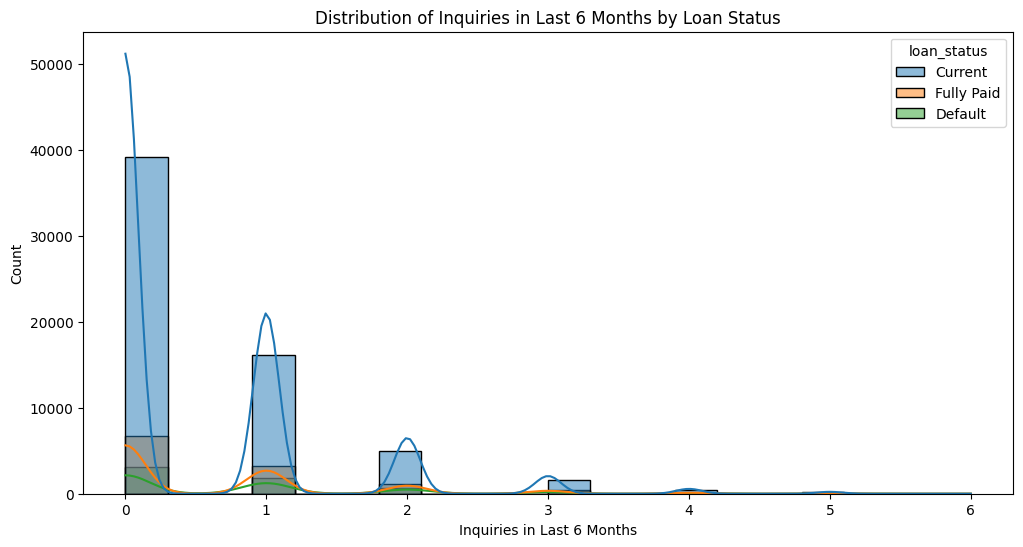

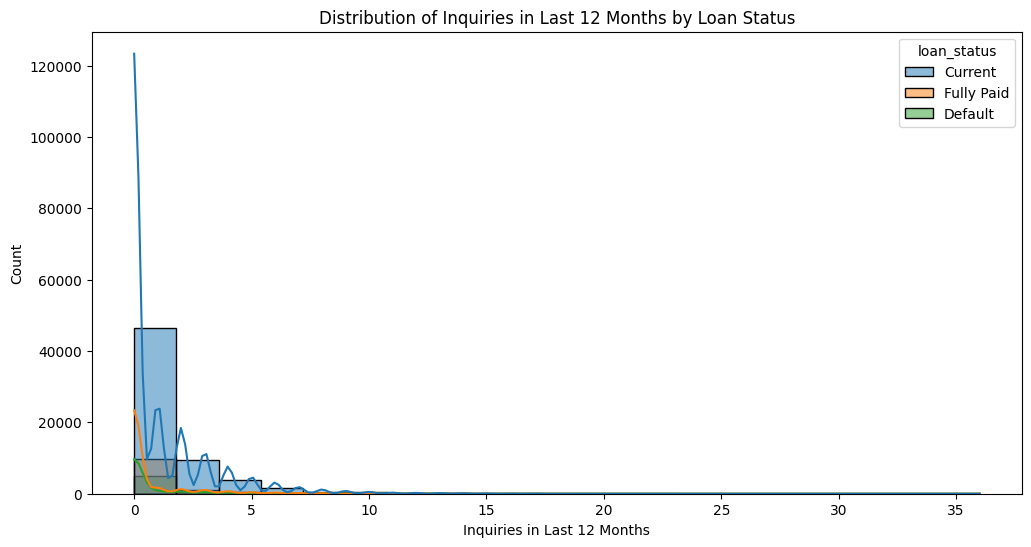

<ipython-input-9-9ea9e1c4c399>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_pandas, x='loan_status', y='inq_last_6mths', ci=None)


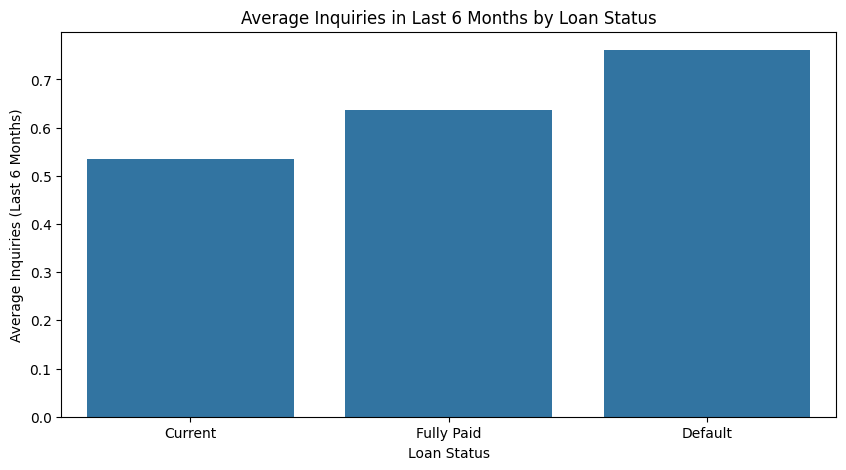

<ipython-input-9-9ea9e1c4c399>:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_pandas, x='loan_status', y='inq_last_12m', ci=None)


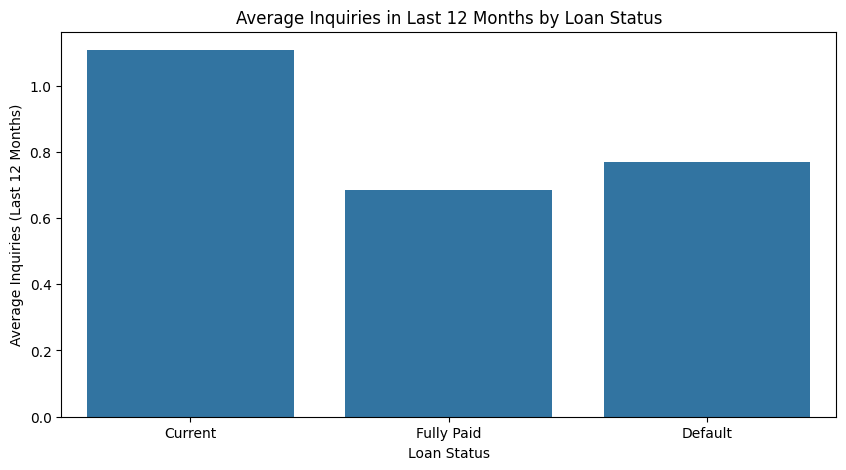

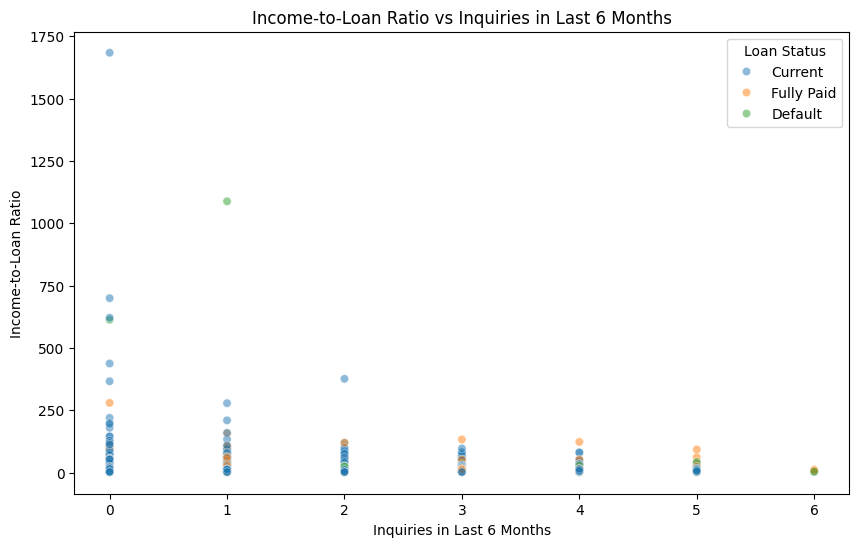

<ipython-input-9-9ea9e1c4c399>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_6m = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('inq_6_month_bucket').size() / data_pandas.groupby('inq_6_month_bucket').size()
<ipython-input-9-9ea9e1c4c399>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_6m = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('inq_6_month_bucket').size() / data_pandas.groupby('inq_6_month_bucket').size()
<ipython-input-9-9ea9e1c4c399>:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ve

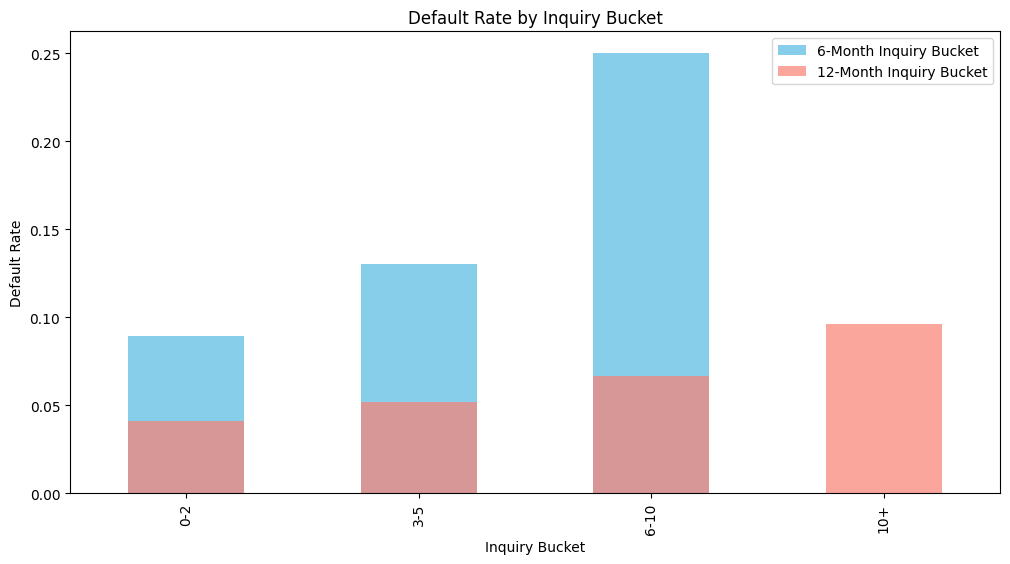

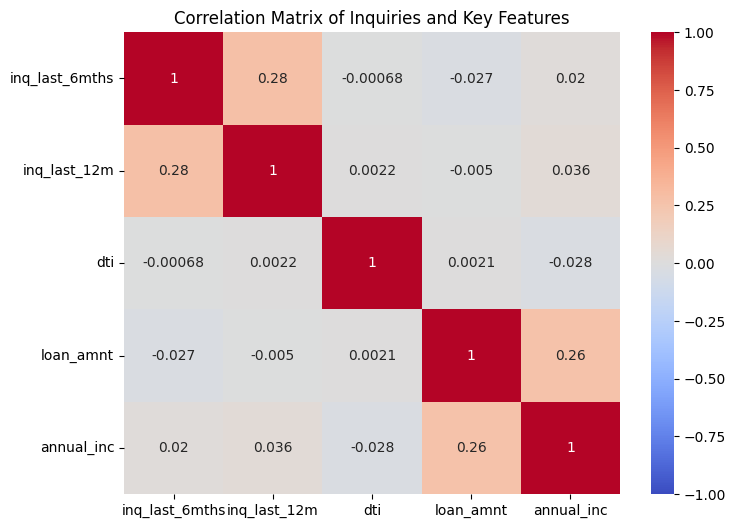

<ipython-input-9-9ea9e1c4c399>:88: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=fico_inquiries, x='fico_category', y='inq_last_6mths', ci=None)


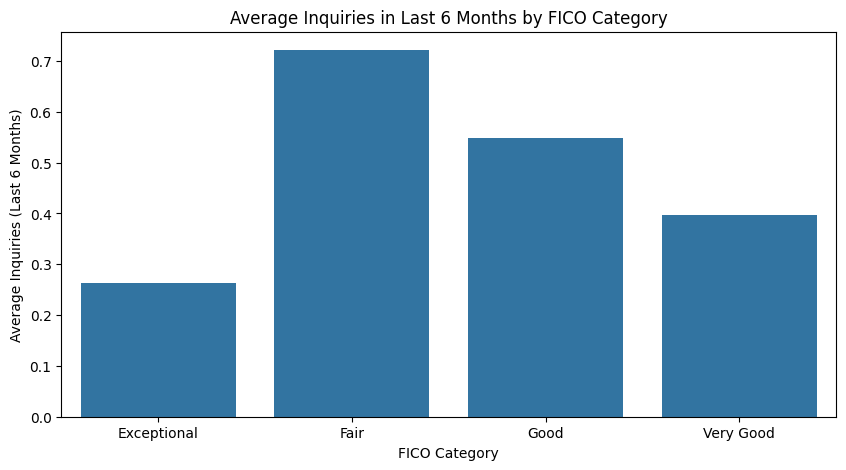

<ipython-input-9-9ea9e1c4c399>:95: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=fico_inquiries, x='fico_category', y='inq_last_12m', ci=None)


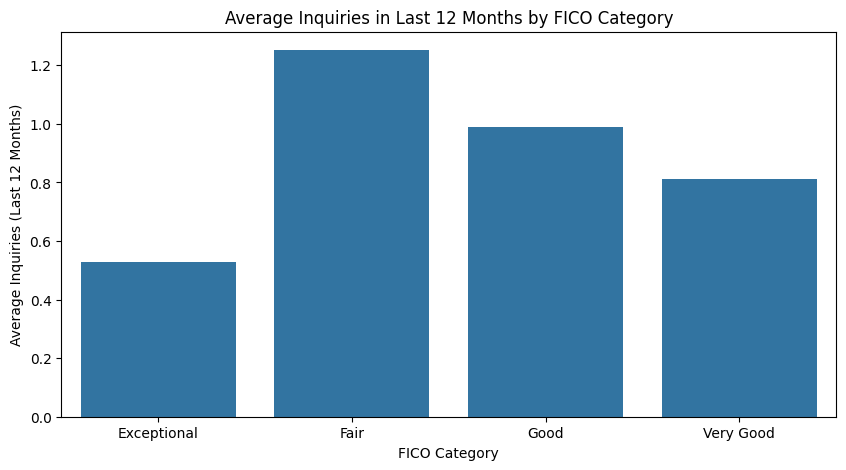

In [9]:
data_pandas = data.to_pandas()

#cleaning inquiries columns
data_pandas['inq_last_6mths'] = pd.to_numeric(data_pandas['inq_last_6mths'], errors='coerce').fillna(0)
data_pandas['inq_last_12m'] = pd.to_numeric(data_pandas['inq_last_12m'], errors='coerce').fillna(0)

#1. Distribution of Inquiries by Loan Status
plt.figure(figsize=(12, 6))
sns.histplot(data=data_pandas, x='inq_last_6mths', hue='loan_status', kde=True, bins=20)
plt.title("Distribution of Inquiries in Last 6 Months by Loan Status")
plt.xlabel("Inquiries in Last 6 Months")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data_pandas, x='inq_last_12m', hue='loan_status', kde=True, bins=20)
plt.title("Distribution of Inquiries in Last 12 Months by Loan Status")
plt.xlabel("Inquiries in Last 12 Months")
plt.ylabel("Count")
plt.show()

#2. Average Inquiries by Loan Status
plt.figure(figsize=(10, 5))
sns.barplot(data=data_pandas, x='loan_status', y='inq_last_6mths', ci=None)
plt.title("Average Inquiries in Last 6 Months by Loan Status")
plt.ylabel("Average Inquiries (Last 6 Months)")
plt.xlabel("Loan Status")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=data_pandas, x='loan_status', y='inq_last_12m', ci=None)
plt.title("Average Inquiries in Last 12 Months by Loan Status")
plt.ylabel("Average Inquiries (Last 12 Months)")
plt.xlabel("Loan Status")
plt.show()

#3. Relationship Between Inquiries and Income-to-Loan Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_pandas, x='inq_last_6mths', y='income_to_loan_ratio', hue='loan_status', alpha=0.5)
plt.title("Income-to-Loan Ratio vs Inquiries in Last 6 Months")
plt.xlabel("Inquiries in Last 6 Months")
plt.ylabel("Income-to-Loan Ratio")
plt.legend(title="Loan Status")
plt.show()

#4. Bucketed Inquiries and Default Rate
data_pandas['inq_6_month_bucket'] = pd.cut(data_pandas['inq_last_6mths'], bins=[0, 2, 5, 10, float('inf')], labels=['0-2', '3-5', '6-10', '10+'])
data_pandas['inq_12_month_bucket'] = pd.cut(data_pandas['inq_last_12m'], bins=[0, 2, 5, 10, float('inf')], labels=['0-2', '3-5', '6-10', '10+'])

default_rate_6m = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('inq_6_month_bucket').size() / data_pandas.groupby('inq_6_month_bucket').size()
default_rate_12m = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('inq_12_month_bucket').size() / data_pandas.groupby('inq_12_month_bucket').size()

plt.figure(figsize=(12, 6))
default_rate_6m.plot(kind='bar', color='skyblue', label='6-Month Inquiry Bucket')
default_rate_12m.plot(kind='bar', color='salmon', label='12-Month Inquiry Bucket', alpha=0.7)
plt.title("Default Rate by Inquiry Bucket")
plt.xlabel("Inquiry Bucket")
plt.ylabel("Default Rate")
plt.legend()
plt.show()

#5. Correlation Analysis Between Inquiries and Other Features
corr_matrix = data_pandas[['inq_last_6mths', 'inq_last_12m', 'dti', 'loan_amnt', 'annual_inc']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Inquiries and Key Features")
plt.show()

#6. Inquiries with FICO Score Categories
def categorize_fico(fico_score):
    if fico_score < 580:
        return 'Poor'
    elif fico_score < 670:
        return 'Fair'
    elif fico_score < 740:
        return 'Good'
    elif fico_score < 800:
        return 'Very Good'
    else:
        return 'Exceptional'

data_pandas['fico_category'] = data_pandas['fico_range_low'].apply(categorize_fico)

fico_inquiries = data_pandas.groupby('fico_category')[['inq_last_6mths', 'inq_last_12m']].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=fico_inquiries, x='fico_category', y='inq_last_6mths', ci=None)
plt.title("Average Inquiries in Last 6 Months by FICO Category")
plt.xlabel("FICO Category")
plt.ylabel("Average Inquiries (Last 6 Months)")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=fico_inquiries, x='fico_category', y='inq_last_12m', ci=None)
plt.title("Average Inquiries in Last 12 Months by FICO Category")
plt.xlabel("FICO Category")
plt.ylabel("Average Inquiries (Last 12 Months)")
plt.show()


Exploring remaining columns

Categorical Columns: ['issue_d', 'mths_since_last_record', 'home_ownership', 'earliest_cr_line', 'purpose', 'addr_state', 'emp_length_category', 'mths_since_last_delinq']
Numerical Columns: ['id', 'fico_income_interaction', 'acc_now_delinq', 'term_to_income_ratio', 'delinq_2yrs', 'term_numeric', 'emp_length_num', 'delinq_amnt', 'monthly_payment_to_income_ratio']


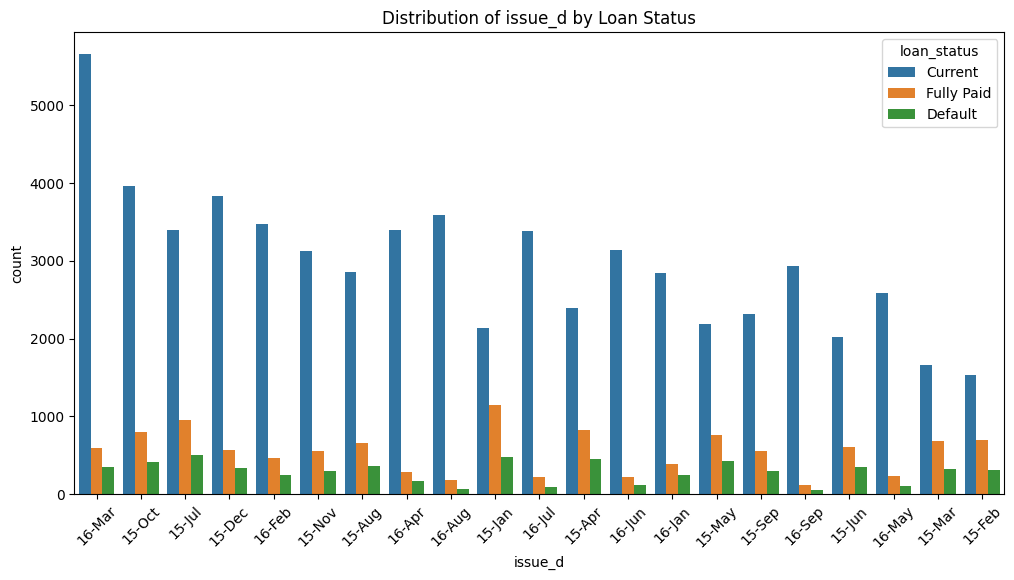

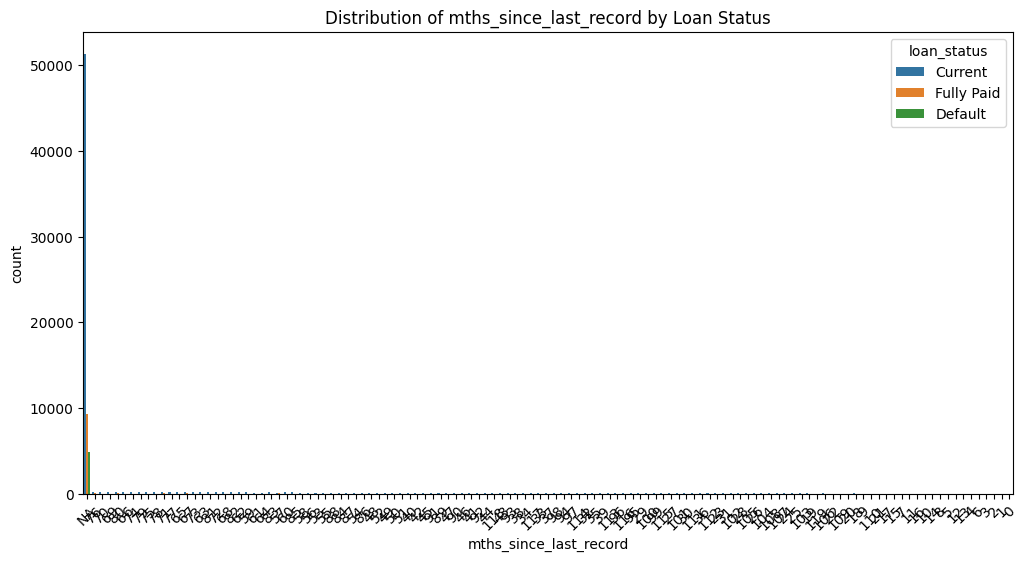

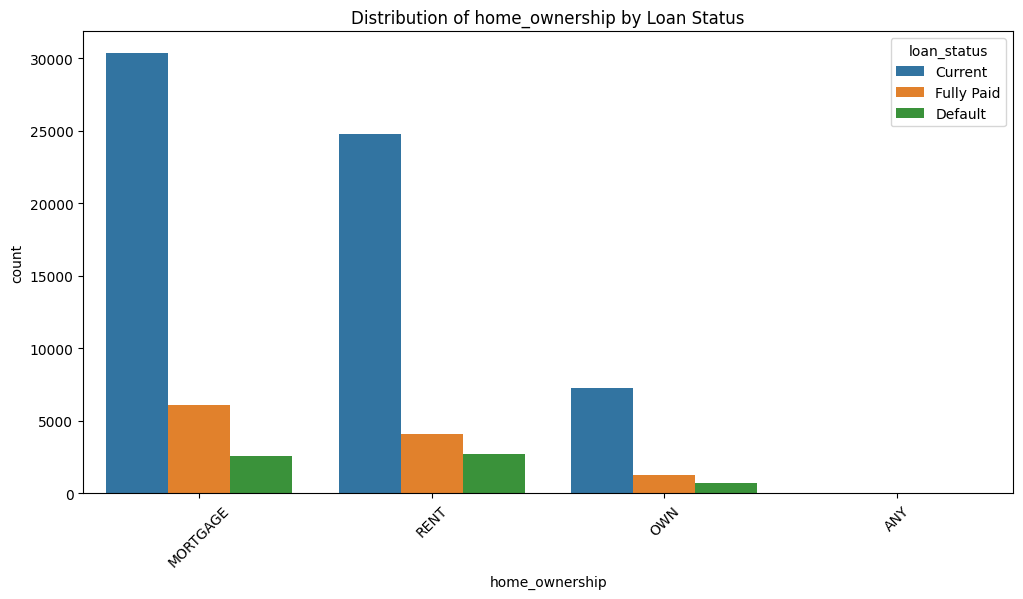

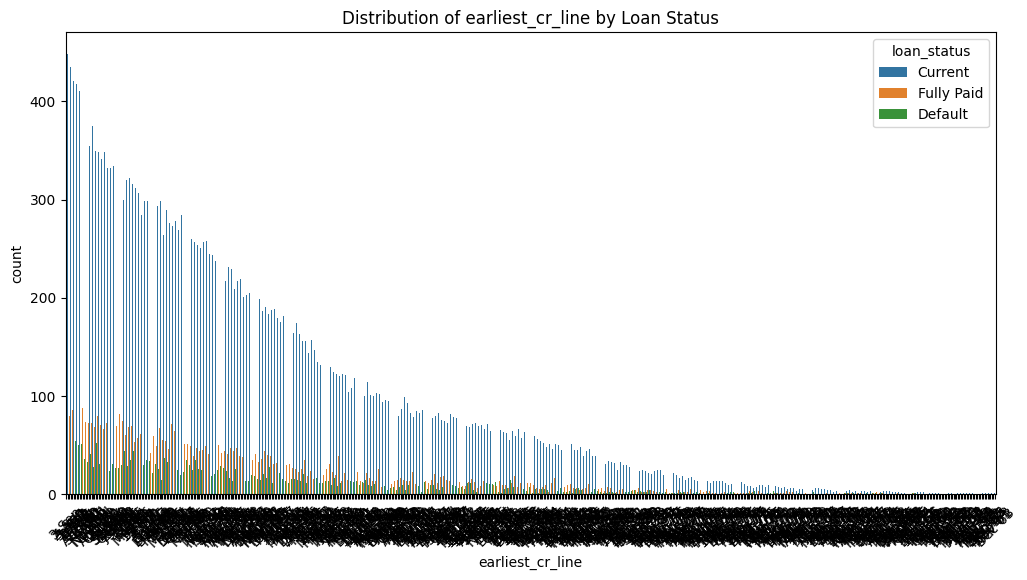

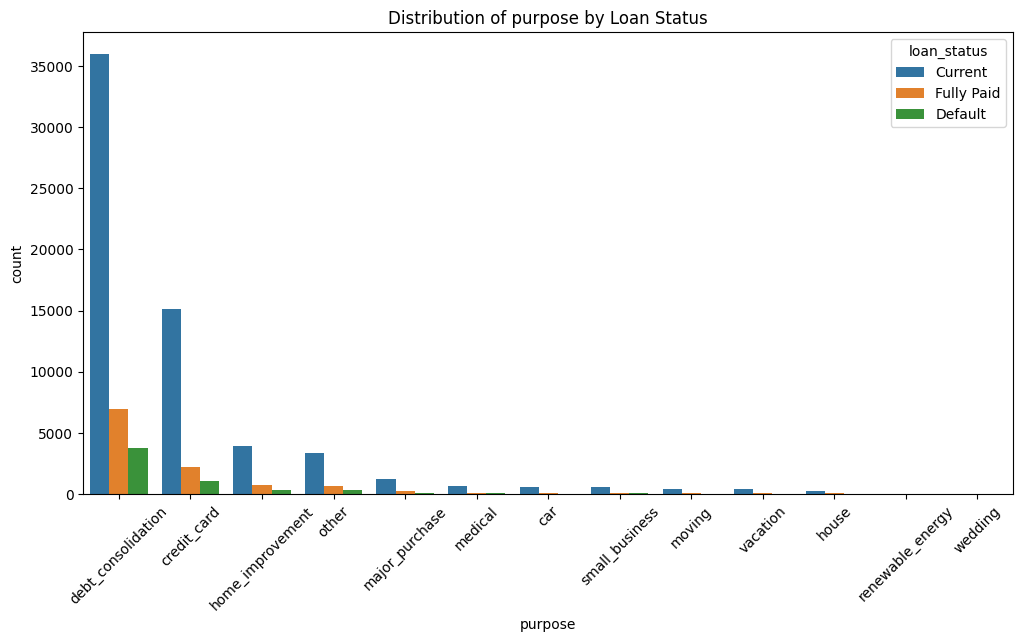

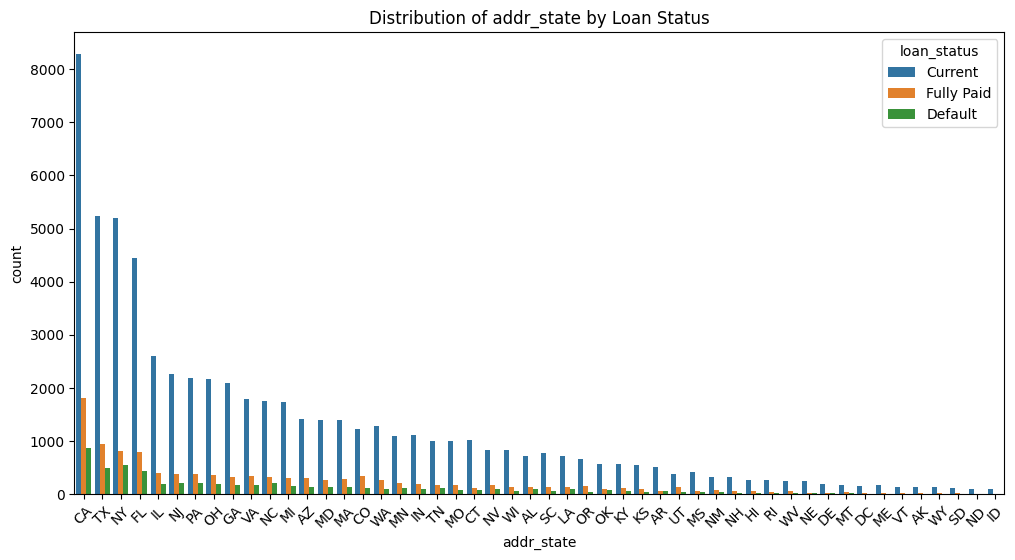

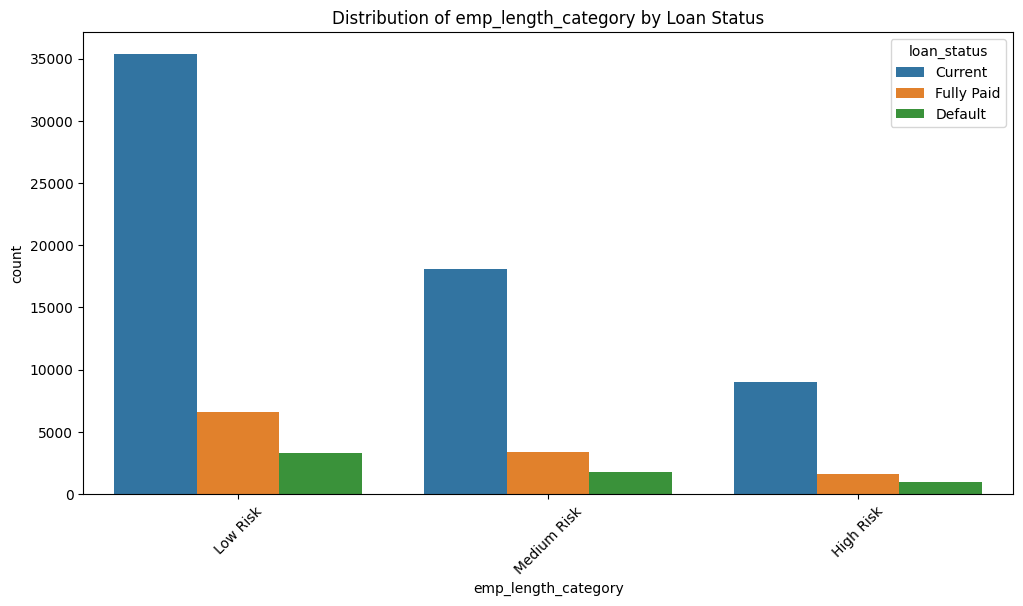

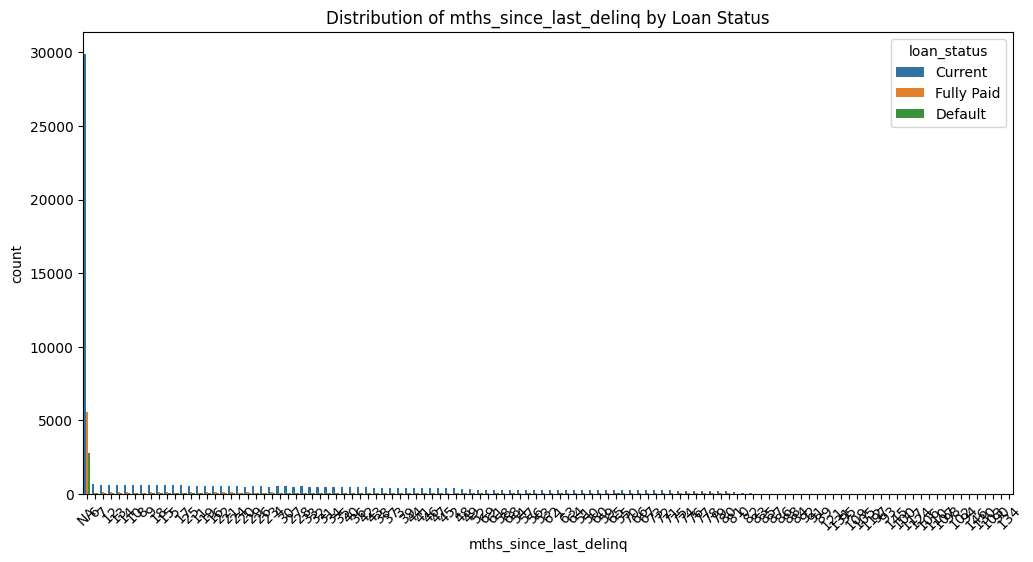

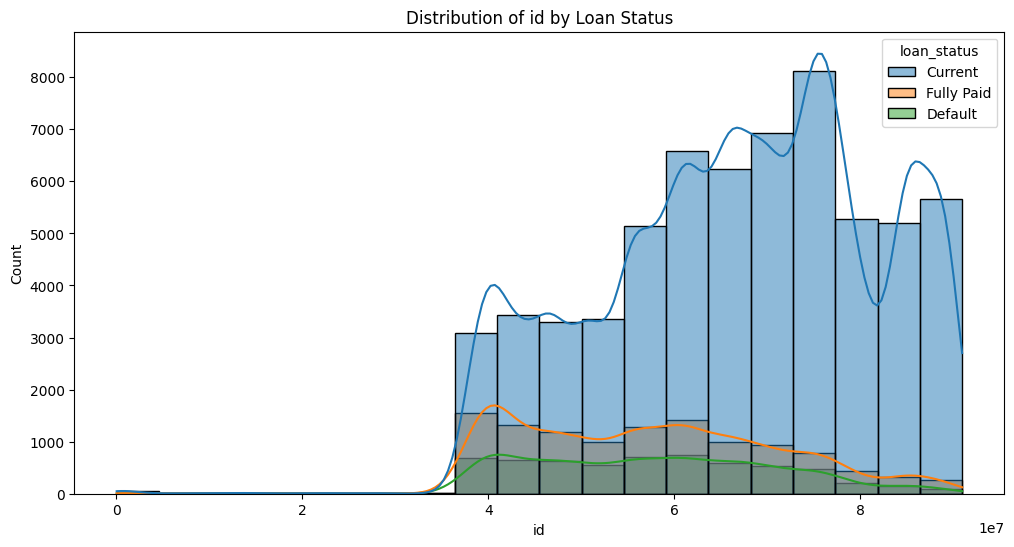

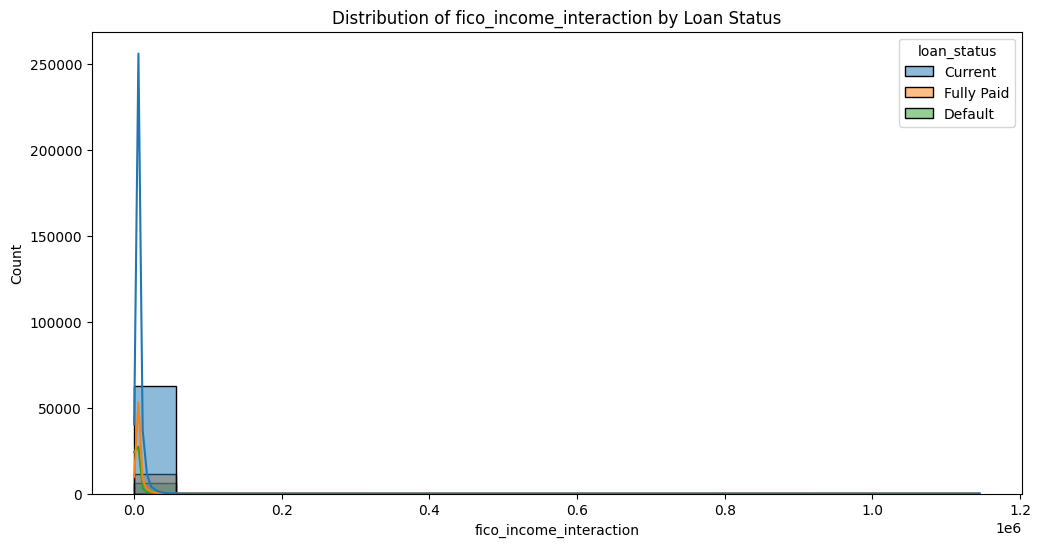

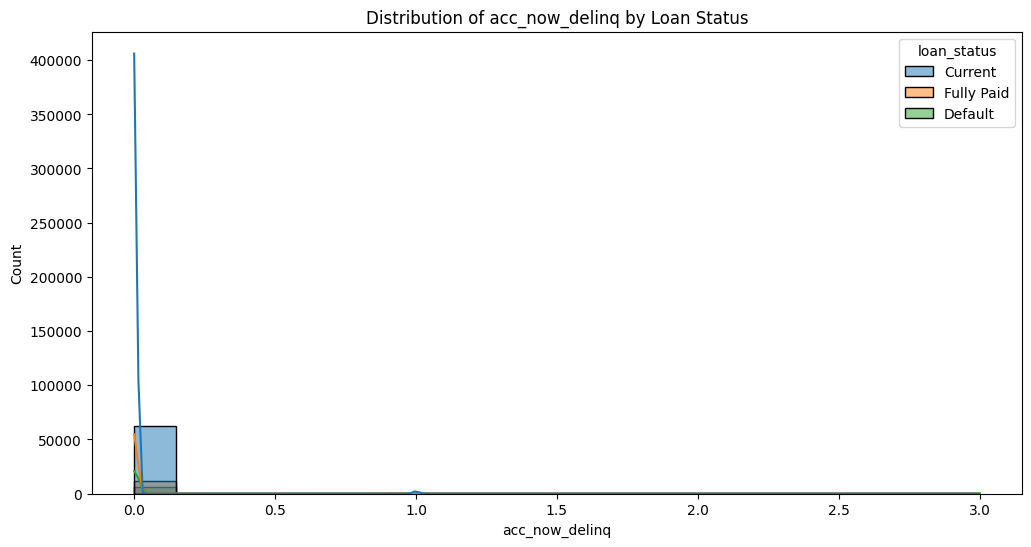

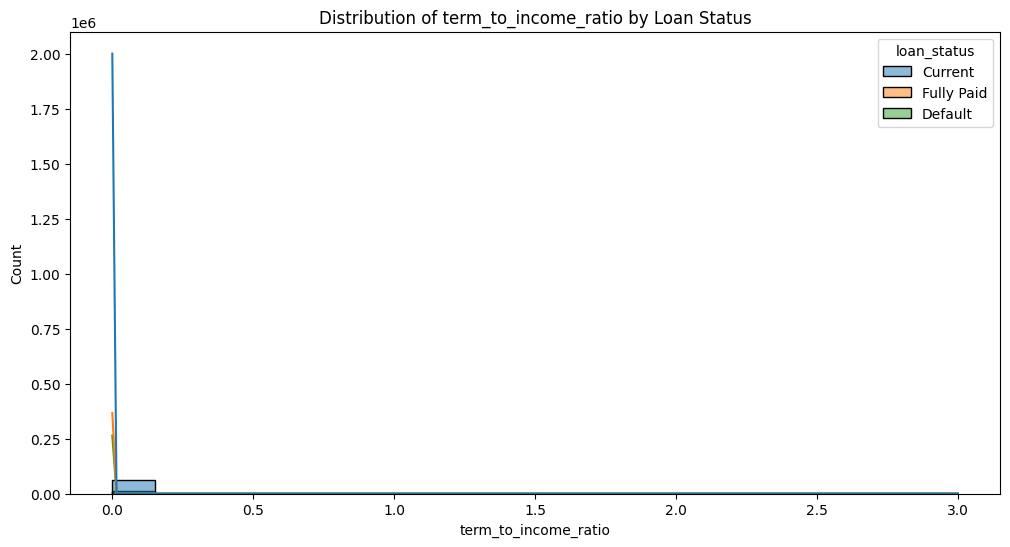

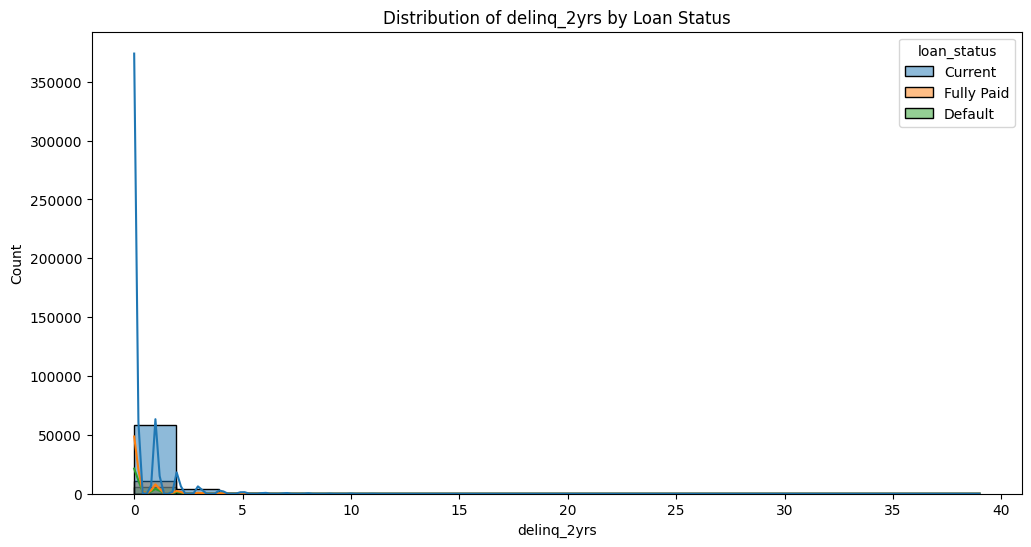

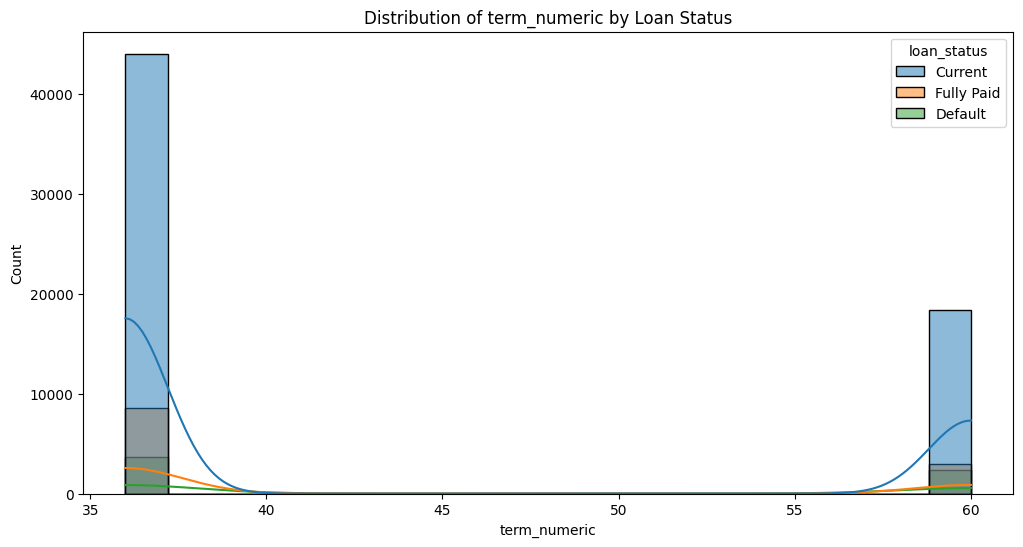

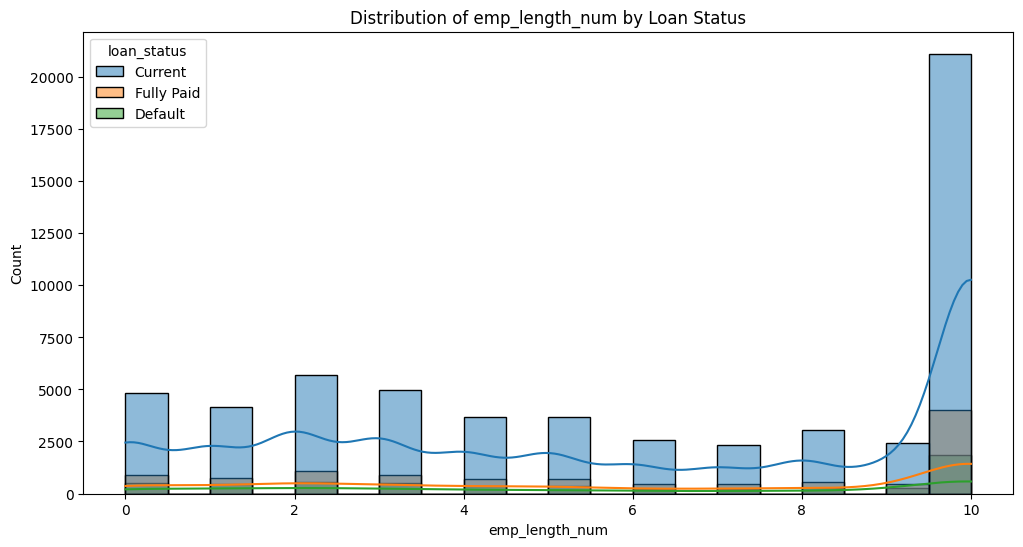

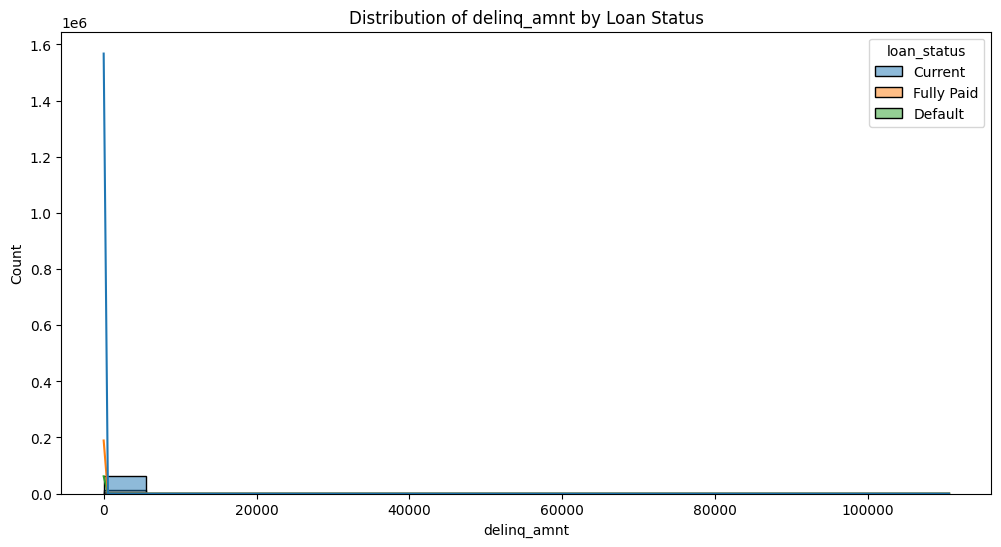

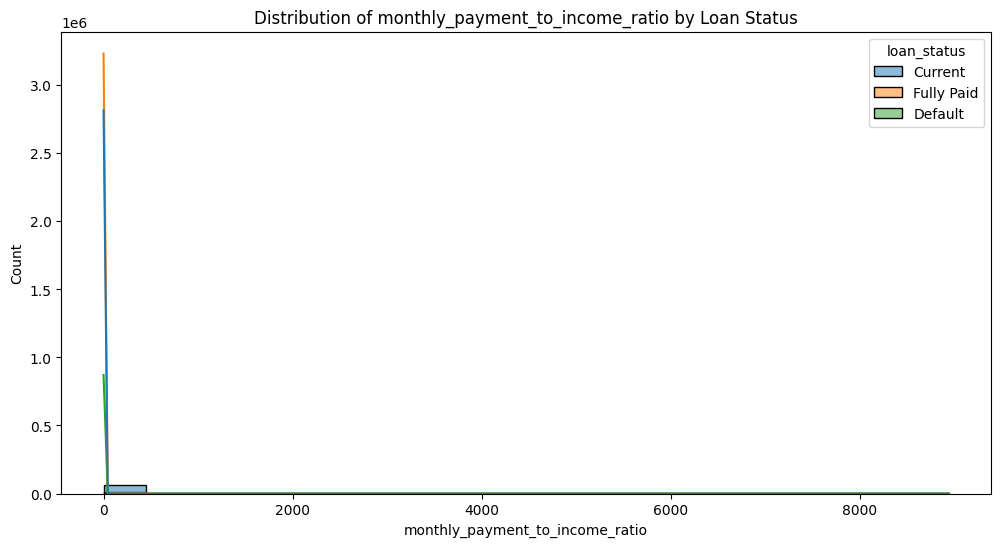

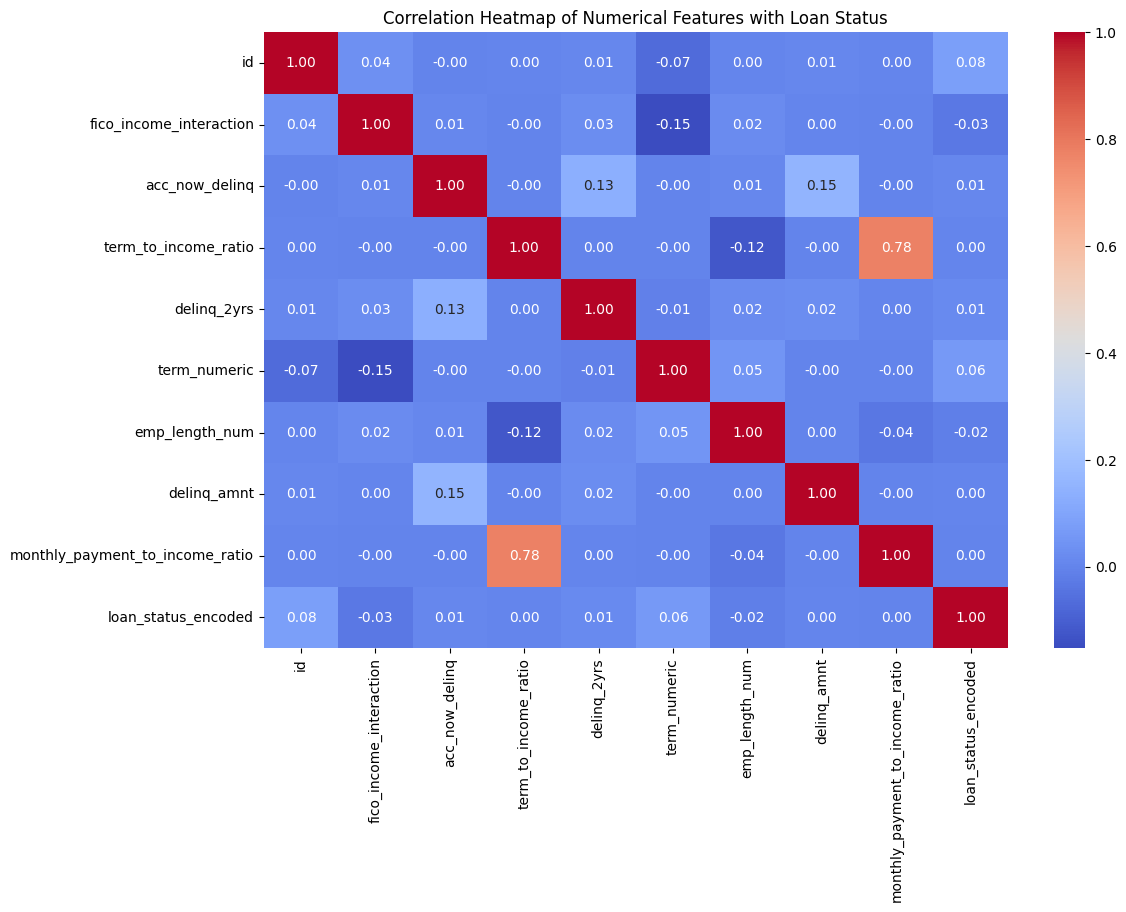

In [10]:
#remaining columns in the dataset
remaining_columns = list(set(data_pandas.columns) - {'annual_inc', 'loan_amnt', 'inq_last_6mths', 'inq_last_12m',
                                                     'fico_range_low', 'fico_range_high', 'loan_status',
                                                     'verification_status', 'dti', 'emp_length',
                                                     'income_to_loan_ratio', 'term', 'installment',
                                                     'fico_category', 'dti_category'})

#separating columns into categorical and numerical
categorical_columns = [col for col in remaining_columns if data_pandas[col].dtype == 'object']
numerical_columns = [col for col in remaining_columns if data_pandas[col].dtype in ['int64', 'float64']]

print(f"Categorical Columns: {categorical_columns}")
print(f"Numerical Columns: {numerical_columns}")

def plot_categorical(column):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_pandas, x=column, hue='loan_status', order=data_pandas[column].value_counts().index)
    plt.title(f"Distribution of {column} by Loan Status")
    plt.xticks(rotation=45)
    plt.show()

def plot_numerical(column):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=data_pandas, x=column, hue='loan_status', kde=True, bins=20)
    plt.title(f"Distribution of {column} by Loan Status")
    plt.xlabel(column)
    plt.show()


for col in categorical_columns:
    try:
        plot_categorical(col)
    except Exception as e:
        print(f"Error processing column {col}: {e}")

for col in numerical_columns:
    try:
        plot_numerical(col)
    except Exception as e:
        print(f"Error processing column {col}: {e}")

#encoding loan_status into numerical values for correlation
data_pandas['loan_status_encoded'] = data_pandas['loan_status'].map({
    'Fully Paid': 0,
    'Current': 1,
    'Default': 2
})

plt.figure(figsize=(12, 8))
sns.heatmap(data_pandas[numerical_columns + ['loan_status_encoded']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features with Loan Status")
plt.show()




Exploring other columns like 'mths_since_last_delinq', 'mths_since_last_record', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs

Correlation with Loan Status:
mths_since_last_delinq   -0.021851
mths_since_last_record    0.006528
acc_now_delinq           -0.005337
delinq_amnt               0.017637
delinq_2yrs              -0.003788
loan_status_encoded       1.000000
Name: loan_status_encoded, dtype: float64


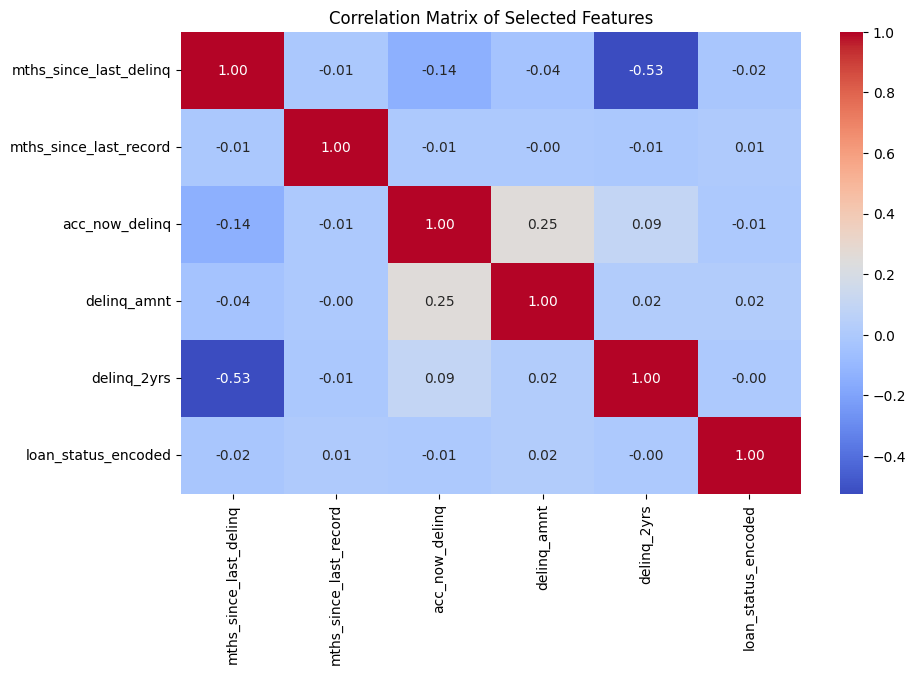

Correlation with Loan Status:
mths_since_last_delinq   -0.025583
mths_since_last_record   -0.011263
acc_now_delinq            0.006934
delinq_amnt               0.004119
delinq_2yrs               0.014490
loan_status_encoded       1.000000
Name: loan_status_encoded, dtype: float64


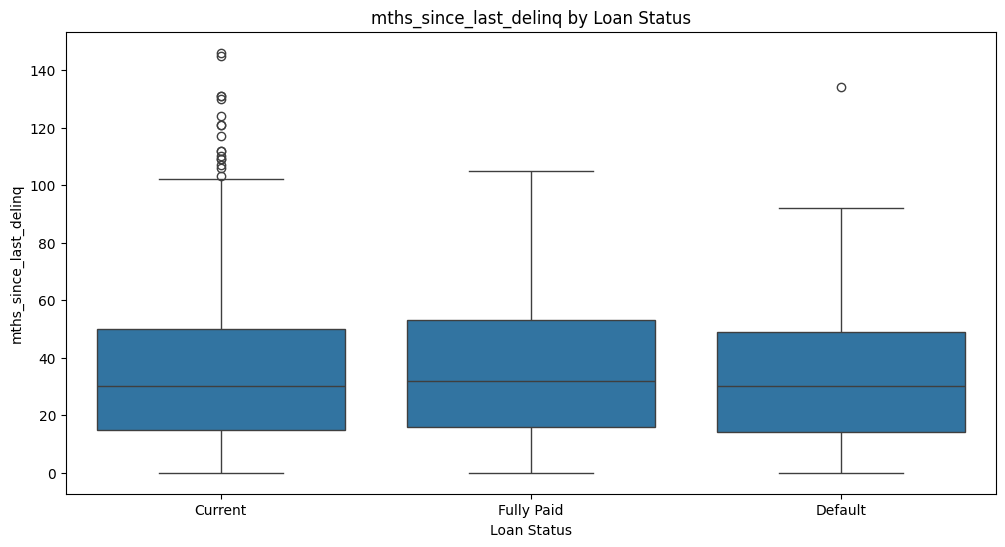

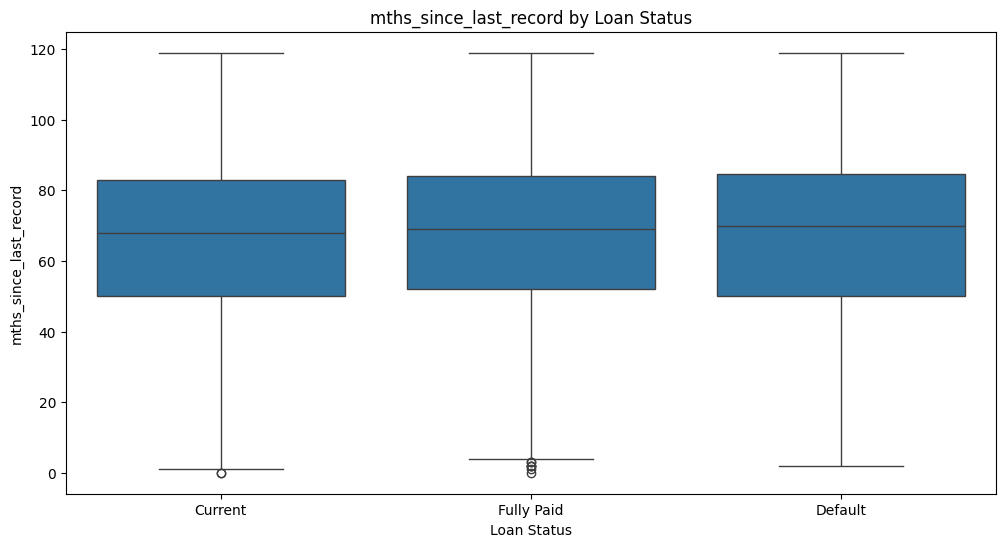

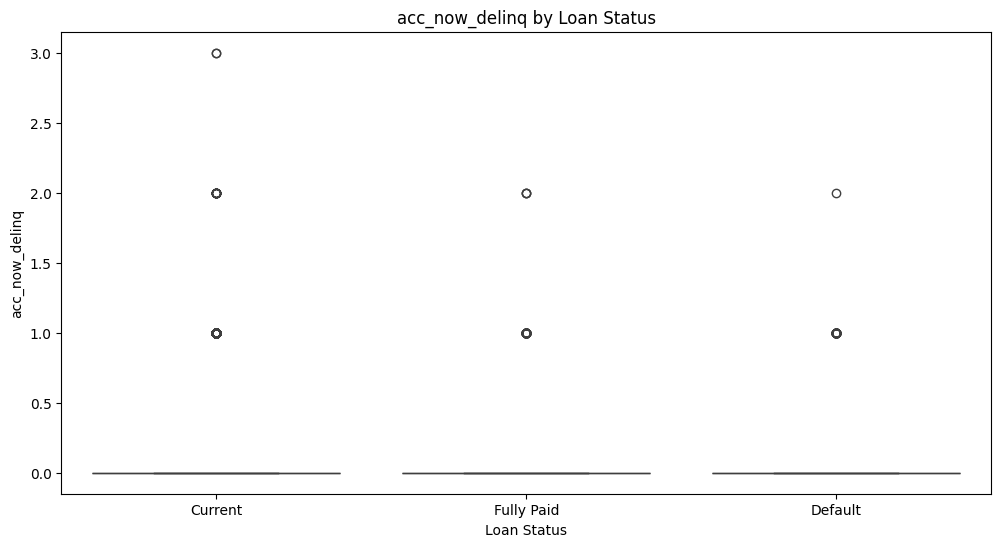

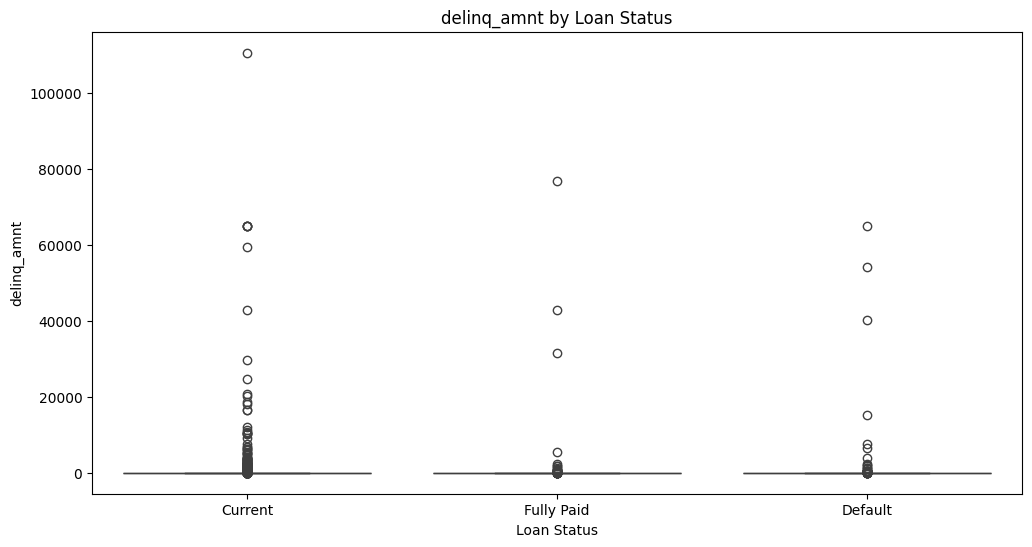

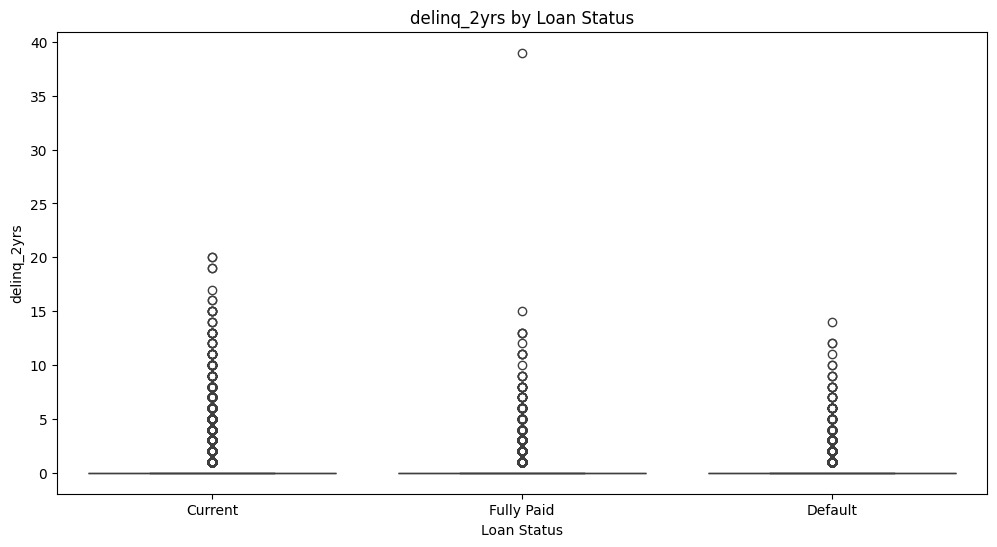

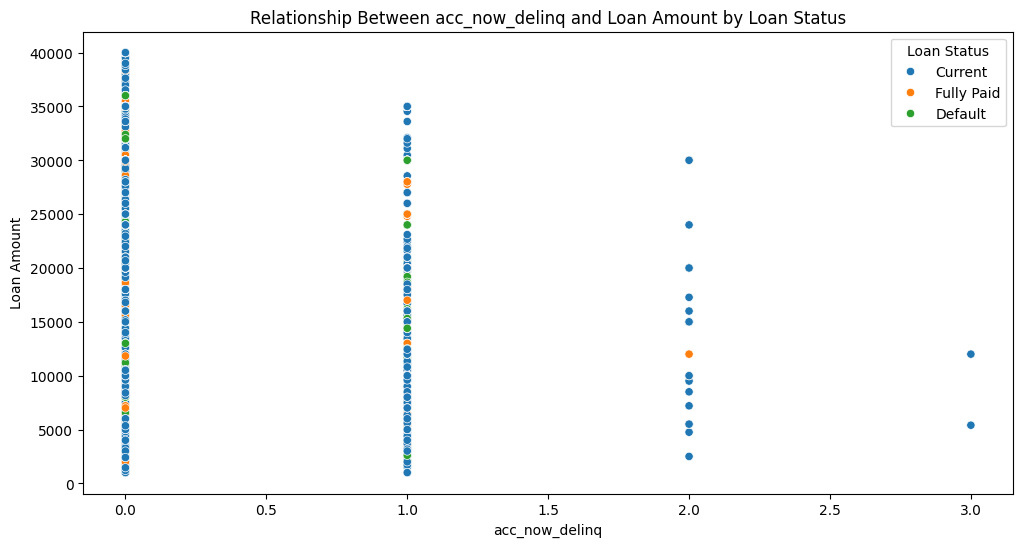

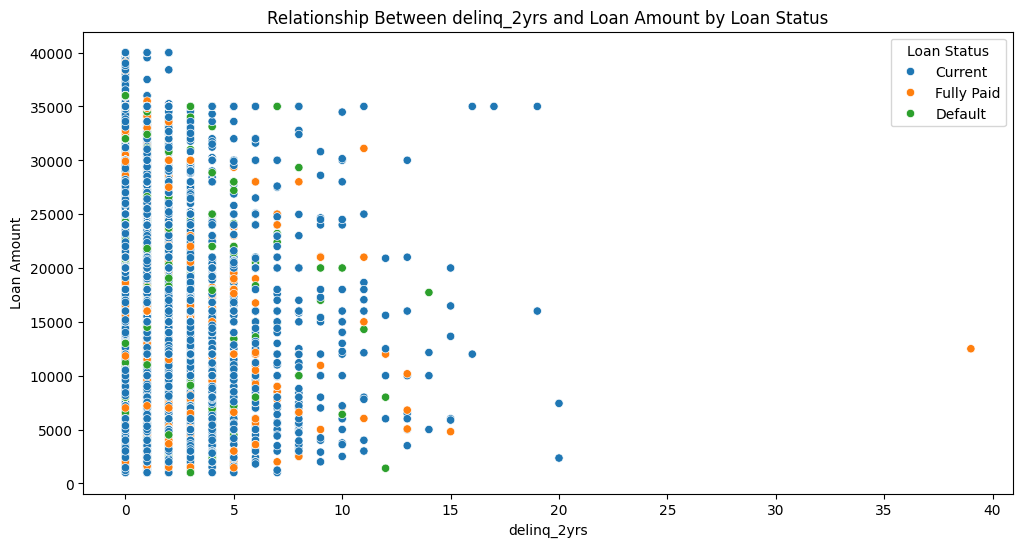

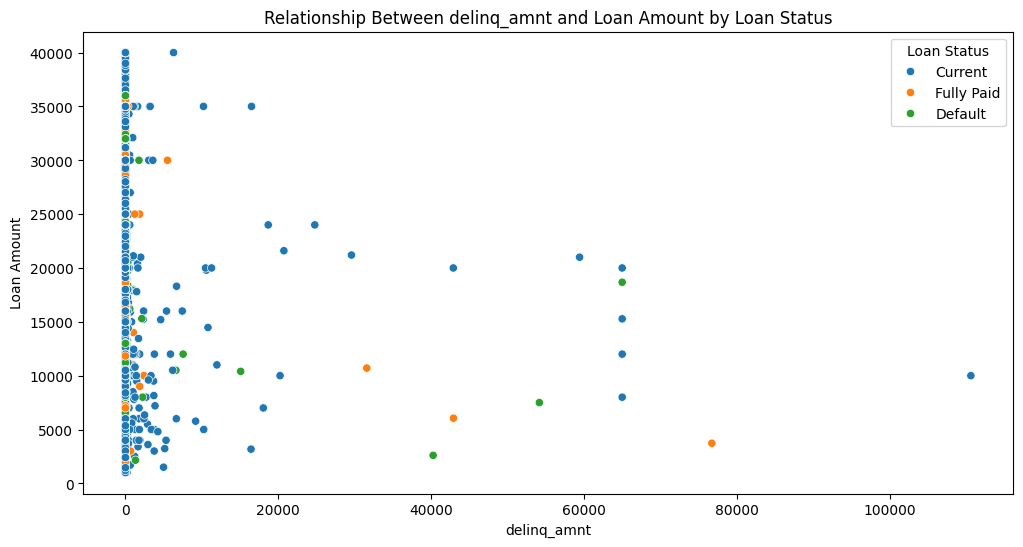

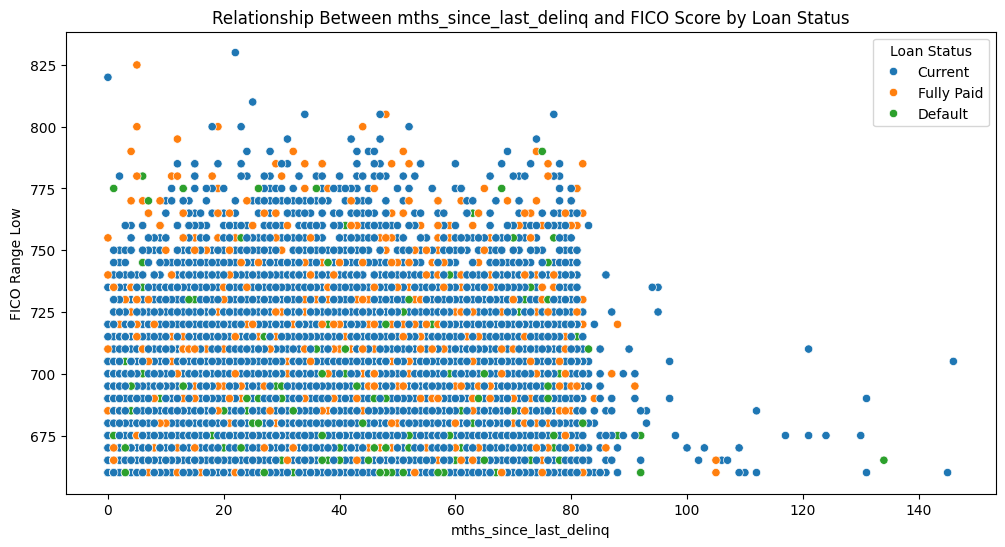

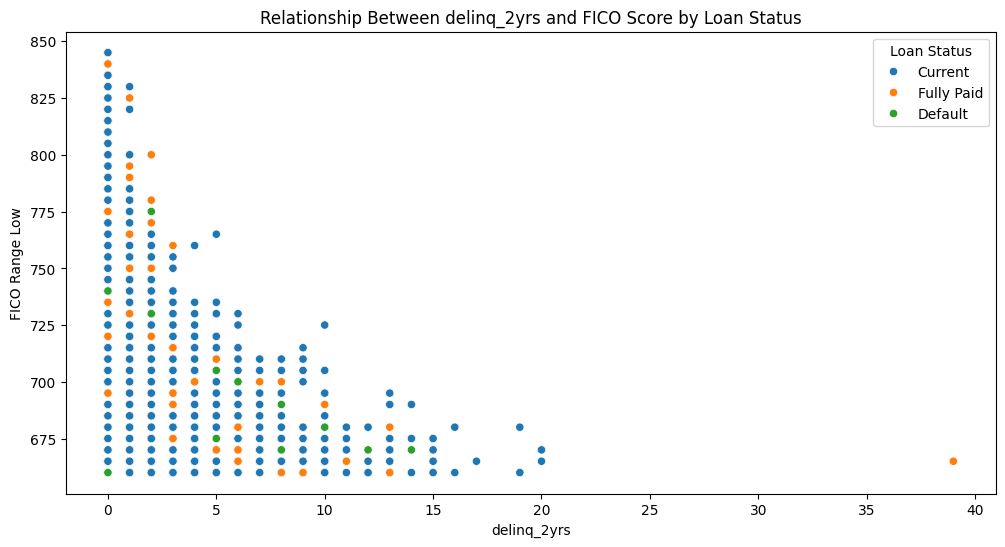

In [11]:
#to Handle non-numeric entries
columns_to_explore = ['mths_since_last_delinq', 'mths_since_last_record', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs']
for col in columns_to_explore:
    data_pandas[col] = pd.to_numeric(data_pandas[col], errors='coerce')

#dropping rows with missing values for correlation calculation
correlation_data = data_pandas[columns_to_explore + ['loan_status_encoded']].dropna()

correlation_matrix = correlation_data.corr()

print("Correlation with Loan Status:")
print(correlation_matrix['loan_status_encoded'])

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Selected Features")
plt.show()


#2. Correlation with Loan Status
data_pandas['loan_status_encoded'] = data_pandas['loan_status'].map({'Fully Paid': 0, 'Current': 1, 'Default': 2})
correlation_matrix = data_pandas[columns_to_explore + ['loan_status_encoded']].corr()
print("Correlation with Loan Status:")
print(correlation_matrix['loan_status_encoded'])

#3. Distribution by Loan Status
for col in columns_to_explore:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data_pandas, x='loan_status', y=col)
    plt.title(f"{col} by Loan Status")
    plt.xlabel("Loan Status")
    plt.ylabel(col)
    plt.show()

#4. Delinquencies and Loan Amount
for col in ['acc_now_delinq', 'delinq_2yrs', 'delinq_amnt']:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data_pandas, x=col, y='loan_amnt', hue='loan_status')
    plt.title(f"Relationship Between {col} and Loan Amount by Loan Status")
    plt.xlabel(col)
    plt.ylabel("Loan Amount")
    plt.legend(title="Loan Status")
    plt.show()

#5. FICO and Delinquencies
for col in ['mths_since_last_delinq', 'delinq_2yrs']:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data_pandas, x=col, y='fico_range_low', hue='loan_status')
    plt.title(f"Relationship Between {col} and FICO Score by Loan Status")
    plt.xlabel(col)
    plt.ylabel("FICO Range Low")
    plt.legend(title="Loan Status")
    plt.show()


Credit score impact on defaults

Loan term impact on defaults

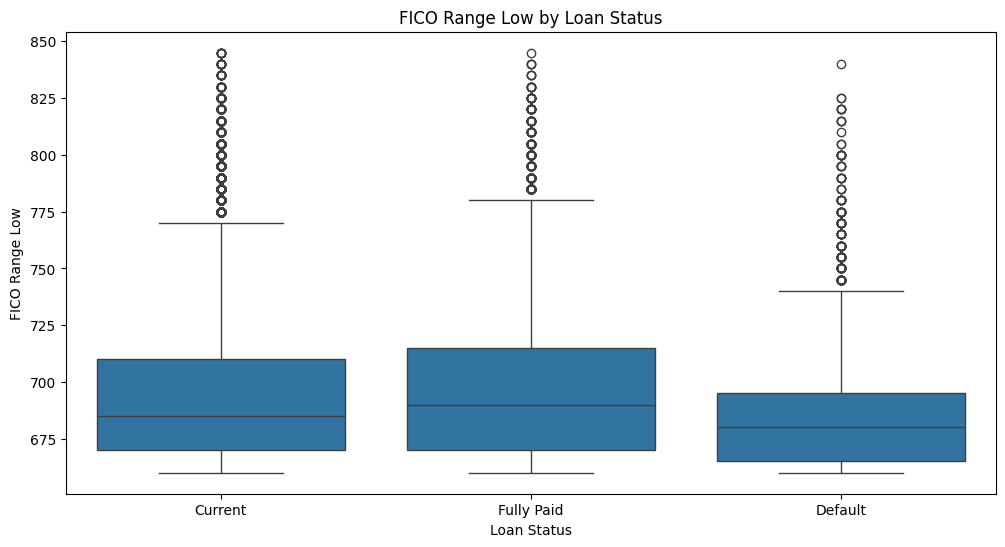

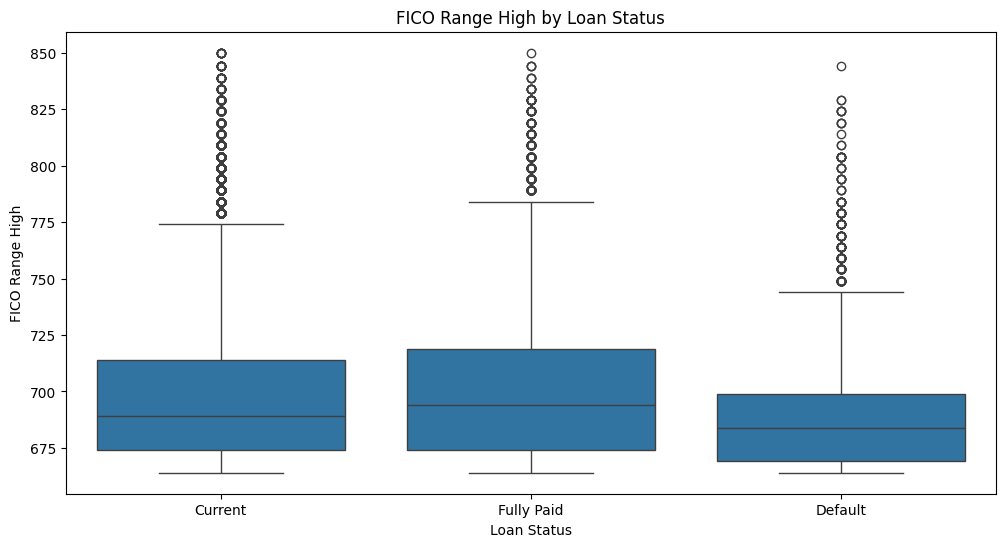

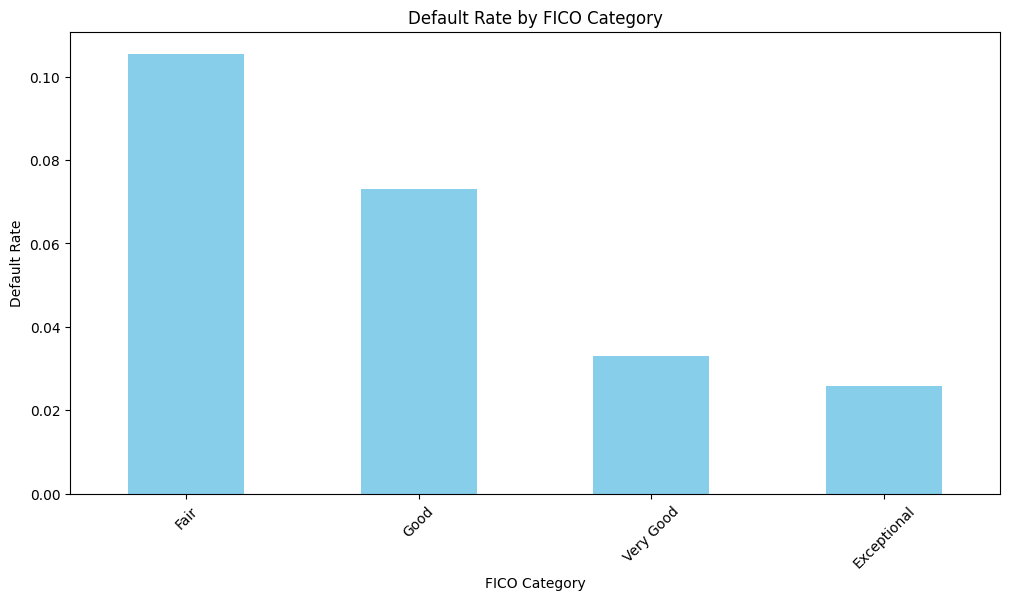

In [12]:
#FICO Score Distribution by Loan Status
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='loan_status', y='fico_range_low')
plt.title("FICO Range Low by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("FICO Range Low")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='loan_status', y='fico_range_high')
plt.title("FICO Range High by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("FICO Range High")
plt.show()

#Credit Scores
def categorize_fico(fico_score):
    if fico_score < 580:
        return 'Poor'
    elif fico_score < 670:
        return 'Fair'
    elif fico_score < 740:
        return 'Good'
    elif fico_score < 800:
        return 'Very Good'
    else:
        return 'Exceptional'

data_pandas['fico_category'] = data_pandas['fico_range_low'].apply(categorize_fico)

#Default Rate by FICO Category
fico_default_rate = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('fico_category').size() / data_pandas.groupby('fico_category').size()

plt.figure(figsize=(12, 6))
fico_default_rate.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Default Rate by FICO Category")
plt.xlabel("FICO Category")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()


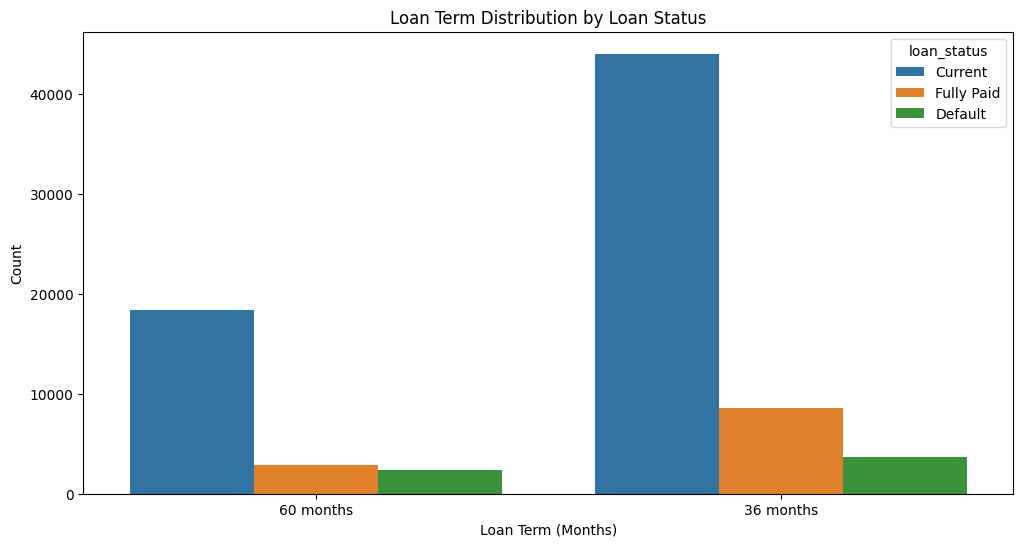

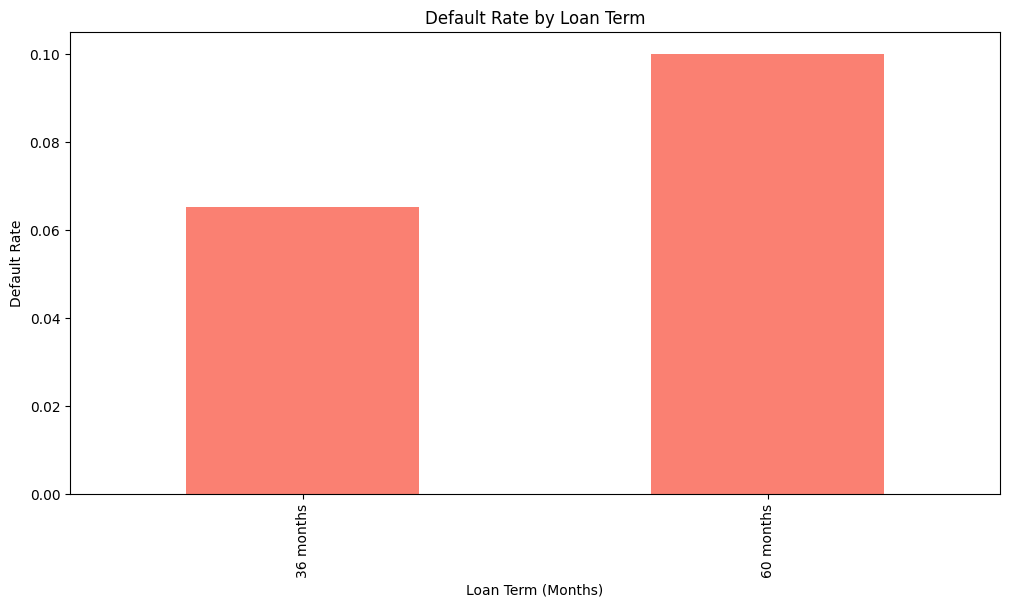

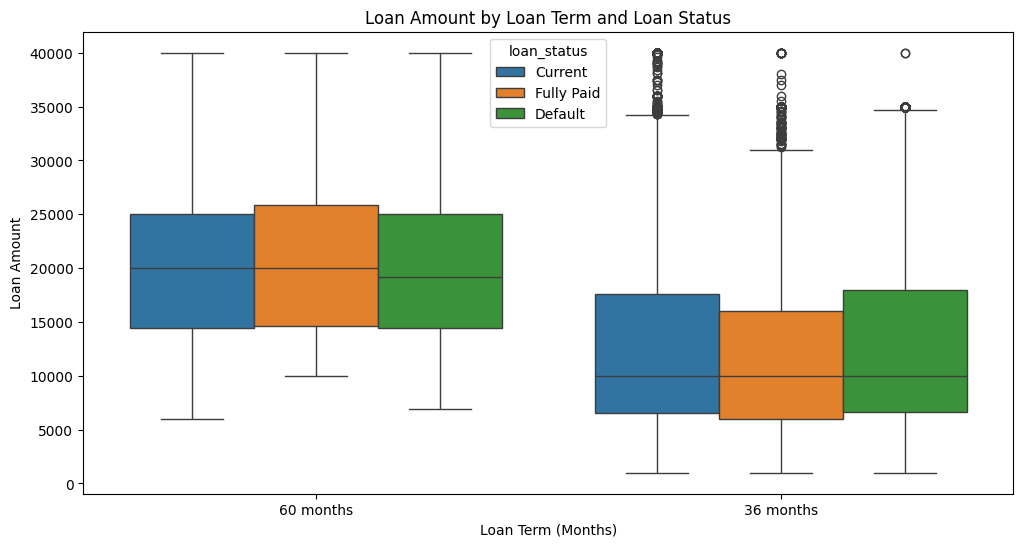

In [13]:
#Loan Term Distribution by Loan Status
plt.figure(figsize=(12, 6))
sns.countplot(data=data_pandas, x='term', hue='loan_status')
plt.title("Loan Term Distribution by Loan Status")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Count")
plt.show()

#Default Rate by Loan Term
loan_term_default_rate = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('term').size() / data_pandas.groupby('term').size()

plt.figure(figsize=(12, 6))
loan_term_default_rate.plot(kind='bar', color='salmon')
plt.title("Default Rate by Loan Term")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Default Rate")
plt.show()

#Loan Amount vs. Loan Term
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='term', y='loan_amnt', hue='loan_status')
plt.title("Loan Amount by Loan Term and Loan Status")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Loan Amount")
plt.show()


1. default rates by loan term

2. loan amounts across FICO categories

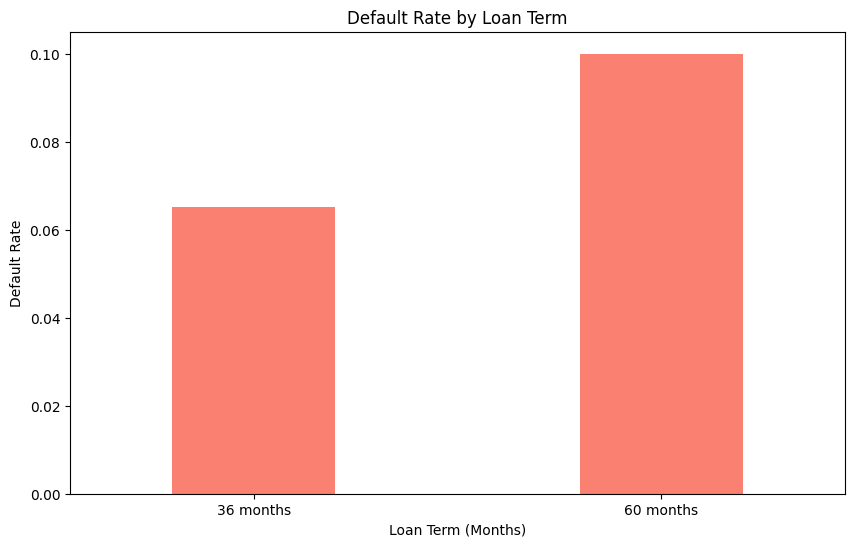

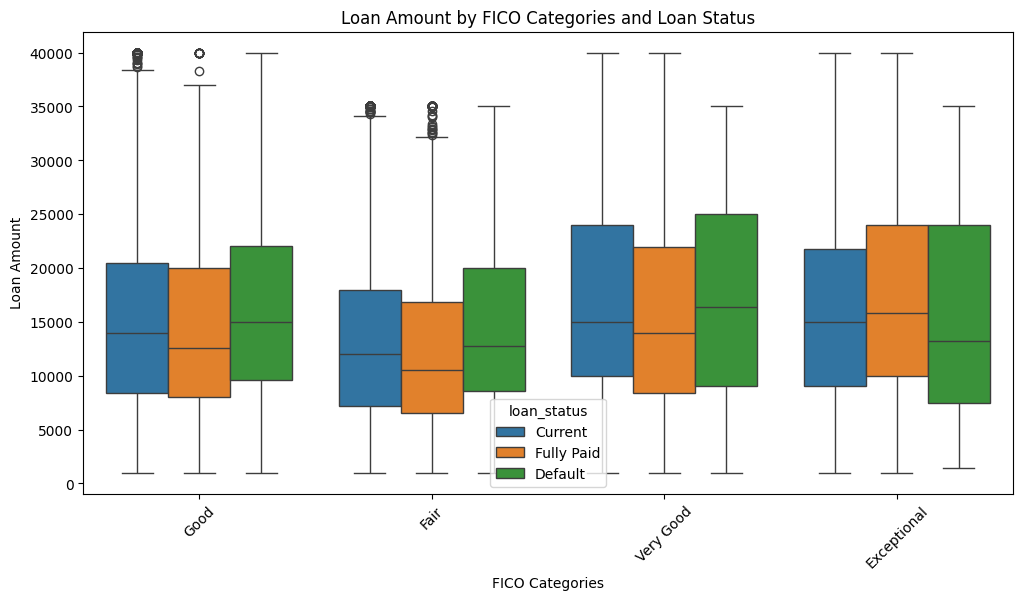

In [14]:
#Default Rate by Loan Term
loan_term_default_rate = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('term').size() / data_pandas.groupby('term').size()

plt.figure(figsize=(10, 6))
loan_term_default_rate.plot(kind='bar', color='salmon', width=0.4)
plt.title("Default Rate by Loan Term")
plt.xlabel("Loan Term (Months)")
plt.ylabel("Default Rate")
plt.xticks(rotation=0)
plt.show()


#FICO Scores
def categorize_fico(fico_score):
    if fico_score < 580:
        return 'Poor'
    elif fico_score < 670:
        return 'Fair'
    elif fico_score < 740:
        return 'Good'
    elif fico_score < 800:
        return 'Very Good'
    else:
        return 'Exceptional'

data_pandas['fico_category'] = data_pandas['fico_range_low'].apply(categorize_fico)

#Loan Amount by FICO Categories
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='fico_category', y='loan_amnt', hue='loan_status')
plt.title("Loan Amount by FICO Categories and Loan Status")
plt.xlabel("FICO Categories")
plt.ylabel("Loan Amount")
plt.xticks(rotation=45)
plt.show()



Analyzing income categories further

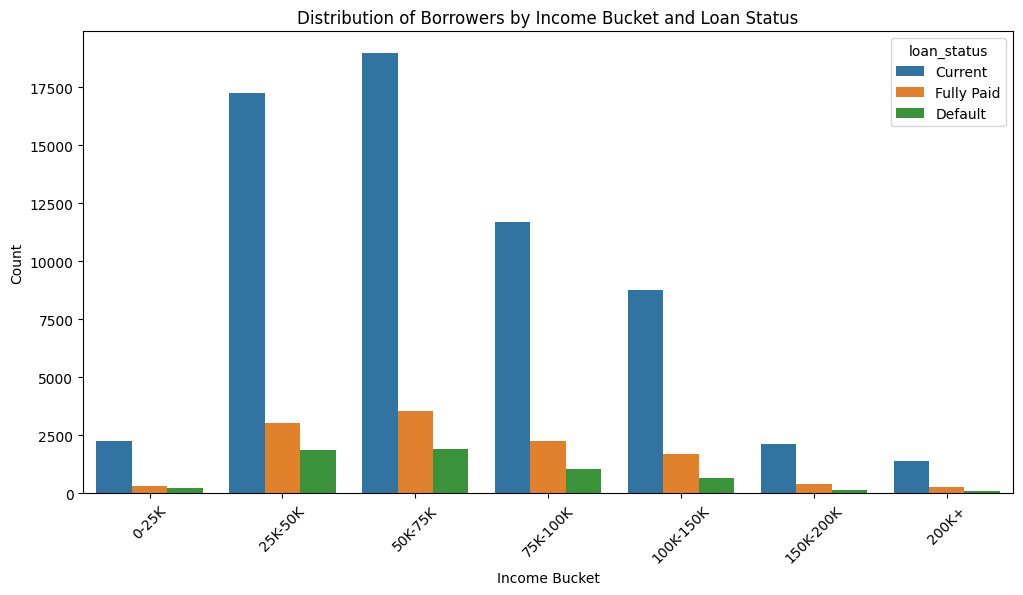

<ipython-input-15-a05c111cd12d>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('income_bucket').size() / data_pandas.groupby('income_bucket').size()
<ipython-input-15-a05c111cd12d>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('income_bucket').size() / data_pandas.groupby('income_bucket').size()


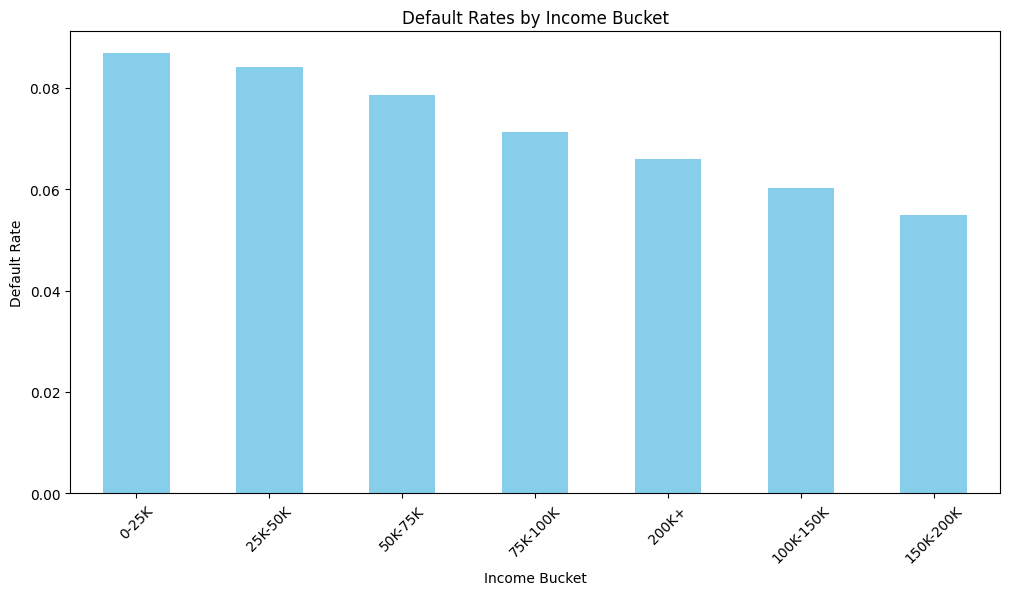

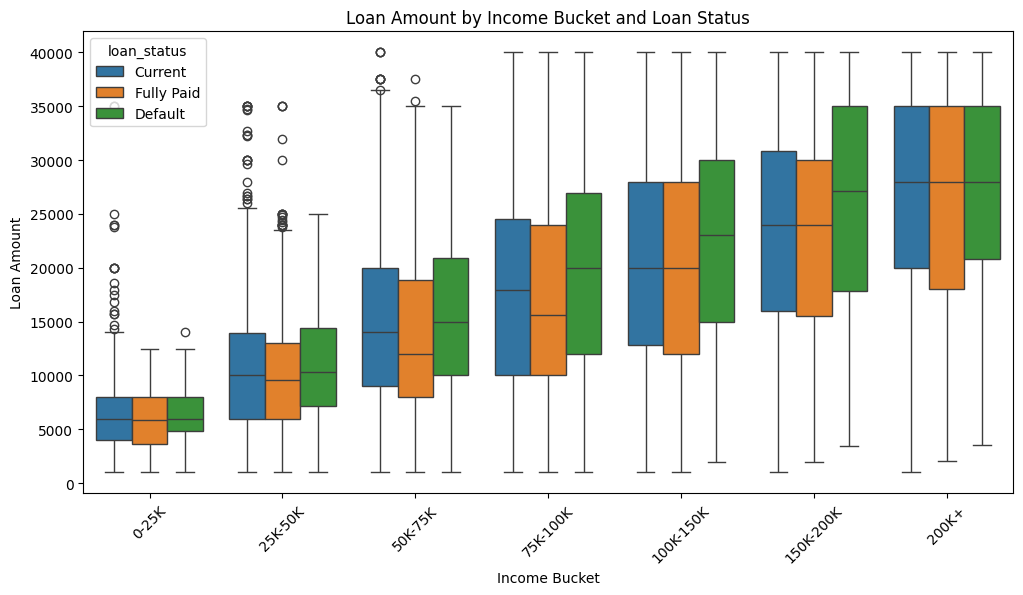

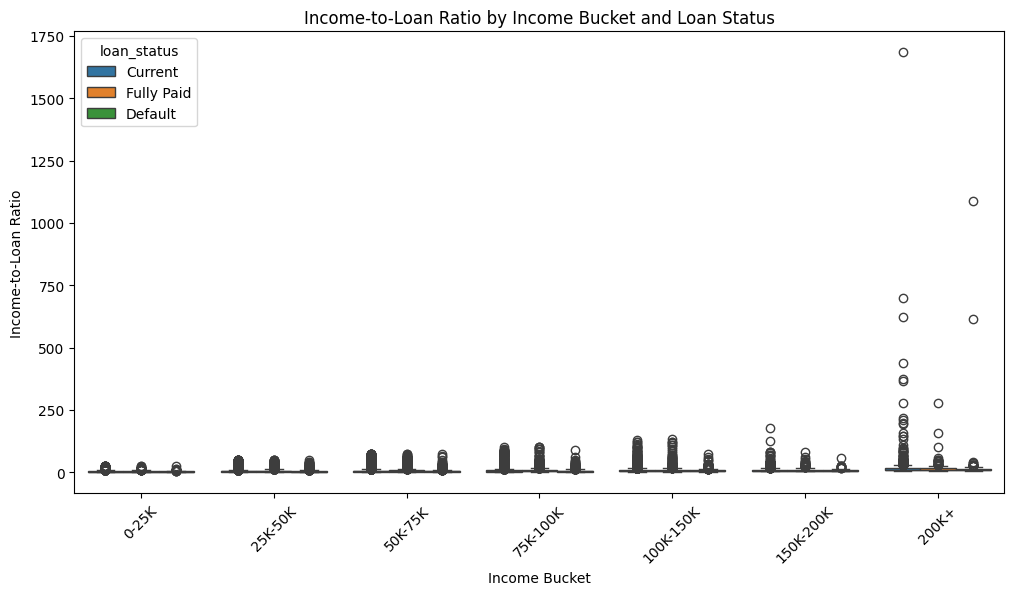

In [15]:
# Define smaller income buckets
bins = [0, 25000, 50000, 75000, 100000, 150000, 200000, data_pandas['annual_inc'].max()]
labels = ['0-25K', '25K-50K', '50K-75K', '75K-100K', '100K-150K', '150K-200K', '200K+']

#Assigning income buckets
data_pandas['income_bucket'] = pd.cut(data_pandas['annual_inc'], bins=bins, labels=labels)

#1. Distribution of Borrowers by Income Bucket
plt.figure(figsize=(12, 6))
sns.countplot(data=data_pandas, x='income_bucket', hue='loan_status', order=labels)
plt.title("Distribution of Borrowers by Income Bucket and Loan Status")
plt.xlabel("Income Bucket")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#2. Default Rates by Income Bucket
default_rates = data_pandas[data_pandas['loan_status'] == 'Default'].groupby('income_bucket').size() / data_pandas.groupby('income_bucket').size()

plt.figure(figsize=(12, 6))
default_rates.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Default Rates by Income Bucket")
plt.xlabel("Income Bucket")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()

#3. Loan Amounts Across Income Buckets
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='income_bucket', y='loan_amnt', hue='loan_status', order=labels)
plt.title("Loan Amount by Income Bucket and Loan Status")
plt.xlabel("Income Bucket")
plt.ylabel("Loan Amount")
plt.xticks(rotation=45)
plt.show()

#4. Income-to-Loan Ratio by Income Bucket
data_pandas['income_to_loan_ratio'] = data_pandas['annual_inc'] / data_pandas['loan_amnt']
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='income_bucket', y='income_to_loan_ratio', hue='loan_status', order=labels)
plt.title("Income-to-Loan Ratio by Income Bucket and Loan Status")
plt.xlabel("Income Bucket")
plt.ylabel("Income-to-Loan Ratio")
plt.xticks(rotation=45)
plt.show()


Compare default rates by income bucket

Investigate the impact of loan purpose.

<ipython-input-16-5ab37a69767d>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('income_bucket').size()
<ipython-input-16-5ab37a69767d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / data_pandas.groupby('income_bucket').size()


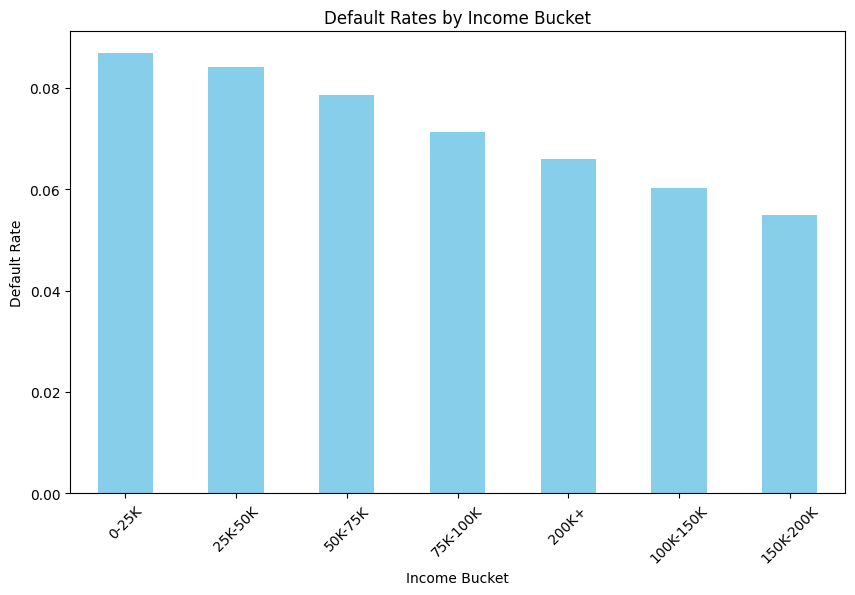

Default Rates by Income Bucket:
income_bucket
0-25K        0.086834
25K-50K      0.084176
50K-75K      0.078668
75K-100K     0.071238
100K-150K    0.060260
150K-200K    0.054912
200K+        0.065947
dtype: float64


In [16]:
# Default Rates by Income Bucket
default_rates_by_income = (
    data_pandas[data_pandas['loan_status'] == 'Default']
    .groupby('income_bucket').size()
    / data_pandas.groupby('income_bucket').size()
)

# Plot Default Rates by Income Bucket
plt.figure(figsize=(10, 6))
default_rates_by_income.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Default Rates by Income Bucket")
plt.xlabel("Income Bucket")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()

print("Default Rates by Income Bucket:")
print(default_rates_by_income)


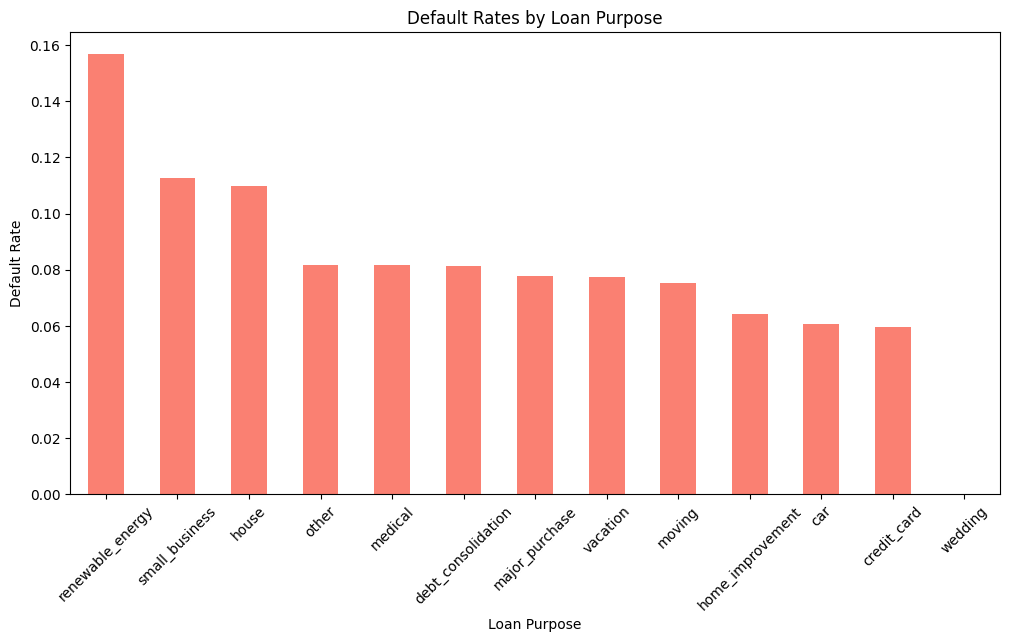

Default Rates by Loan Purpose:
purpose
car                   0.060526
credit_card           0.059722
debt_consolidation    0.081419
home_improvement      0.064158
house                 0.109756
major_purchase        0.077717
medical               0.081731
moving                0.075188
other                 0.081801
renewable_energy      0.156863
small_business        0.112732
vacation              0.077535
wedding                    NaN
dtype: float64


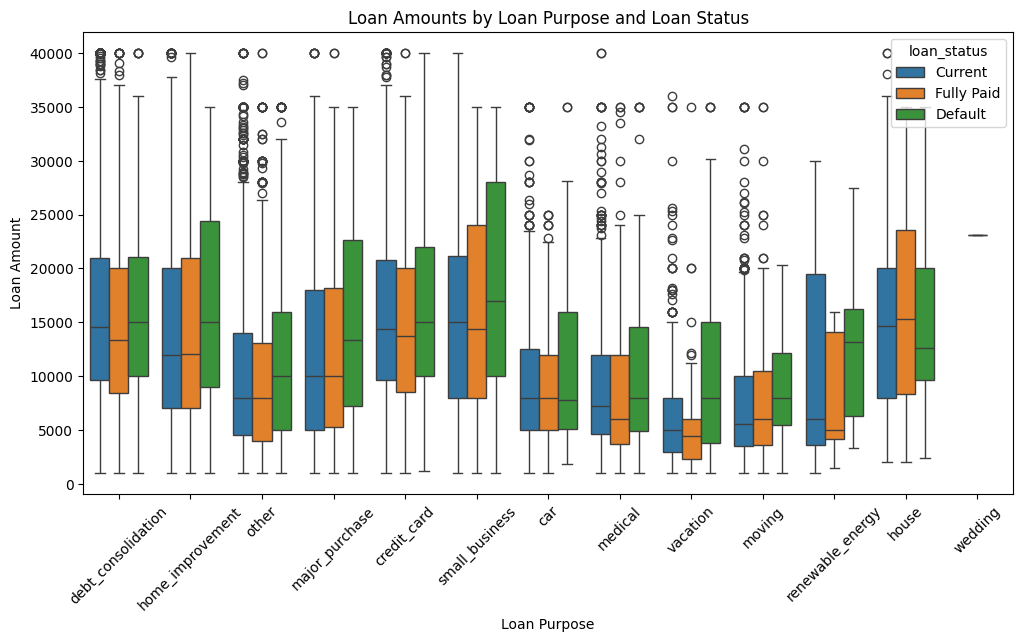

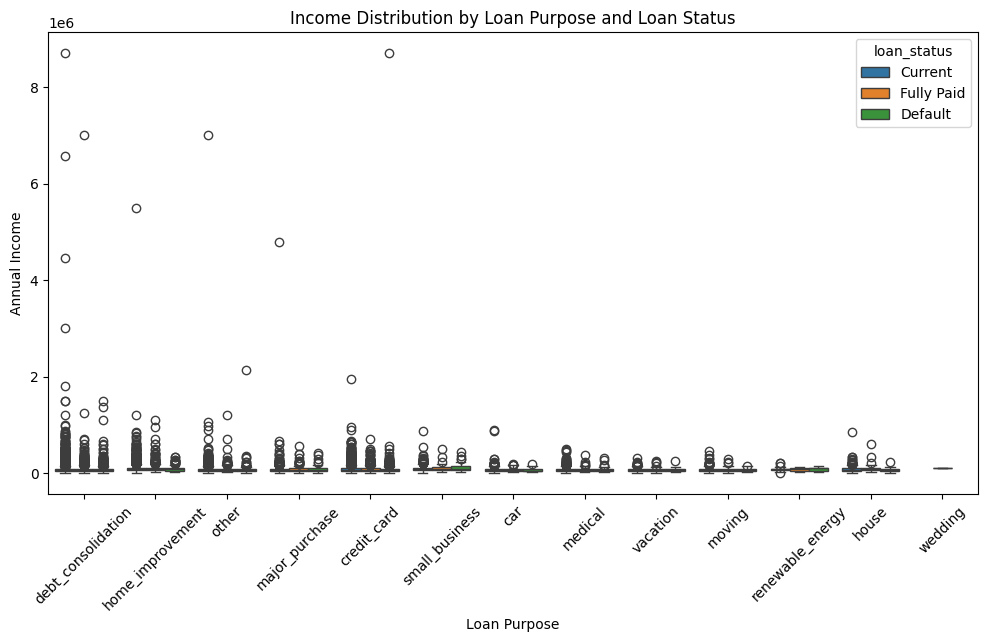

In [17]:
# 1. Default Rates by Loan Purpose
default_rates_by_purpose = (
    data_pandas[data_pandas['loan_status'] == 'Default']
    .groupby('purpose').size()
    / data_pandas.groupby('purpose').size()
)

# Plot Default Rates by Loan Purpose
plt.figure(figsize=(12, 6))
default_rates_by_purpose.sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title("Default Rates by Loan Purpose")
plt.xlabel("Loan Purpose")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()

print("Default Rates by Loan Purpose:")
print(default_rates_by_purpose)

# 2. Loan Amounts by Loan Purpose
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='purpose', y='loan_amnt', hue='loan_status')
plt.title("Loan Amounts by Loan Purpose and Loan Status")
plt.xlabel("Loan Purpose")
plt.ylabel("Loan Amount")
plt.xticks(rotation=45)
plt.show()

# 3. Interaction Between Loan Purpose and Income
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pandas, x='purpose', y='annual_inc', hue='loan_status')
plt.title("Income Distribution by Loan Purpose and Loan Status")
plt.xlabel("Loan Purpose")
plt.ylabel("Annual Income")
plt.xticks(rotation=45)
plt.show()


# **Modeling Approaches**

In [18]:
#copy of the DataFrame for cleaning
data_cleaned = data_df.copy()

# 1. Data Cleaning: Handling missing values
#Print columns in dataset for debugging
print("Columns in dataset:", data_cleaned.columns.tolist())

#handling numerical columns first
numerical_columns = ['annual_inc', 'fico_range_low', 'fico_range_high', 'inq_last_12m']
#finding numerical columns exist in the dataset, impute with mean
existing_num_cols = [col for col in numerical_columns if col in data_cleaned.columns]
if existing_num_cols:
    imputer_num = SimpleImputer(strategy='mean')
    data_cleaned[existing_num_cols] = imputer_num.fit_transform(data_cleaned[existing_num_cols])
else:
    print("Warning: No numerical columns found in the dataset")

#handling term column if it exists
if 'term' in data_cleaned.columns:
    try:
        data_cleaned['term'] = data_cleaned['term'].astype(str)
        data_cleaned['term'] = pd.to_numeric(data_cleaned['term'].str.extract('(\d+)')[0], errors='coerce')
        print("Successfully processed 'term' column")
    except Exception as e:
        print(f"Error processing 'term' column: {e}")

        data_cleaned = data_cleaned.drop(columns=['term'], errors='ignore') ## If there's an error, we drop the term column
else:
    print("Note: 'term' column not found in dataset")

#handking employment length
if 'emp_length_num' in data_cleaned.columns:
    data_cleaned['emp_length_num'] = data_cleaned['emp_length_num'].fillna(data_cleaned['emp_length_num'].median())
else:
    print("Note: 'emp_length_num' column not found in dataset")

# 2. Defining Target Variable
if 'loan_status' in data_cleaned.columns:
    data_cleaned['target'] = data_cleaned['loan_status'].apply(lambda x: 1 if x == 'Default' else 0)
    data_cleaned = data_cleaned.drop(columns=['loan_status'])
    print("Successfully created target variable")
else:
    print("Error: 'loan_status' column not found. Cannot proceed without target variable")
    raise ValueError("Missing required column 'loan_status'")

# 3. Handling categorical variables
categorical_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'emp_length']
existing_cat_cols = [col for col in categorical_columns if col in data_cleaned.columns]

if existing_cat_cols:
    print(f"Processing categorical columns: {existing_cat_cols}")

    data_cleaned = pd.get_dummies(data_cleaned, columns=existing_cat_cols, drop_first=True) #dummies for existing categorical columns
else:
    print("Warning: No categorical columns found in dataset")

#dropping any non-numeric columns
non_numeric_cols = data_cleaned.select_dtypes(exclude=['int64', 'float64']).columns
if len(non_numeric_cols) > 0:
    print(f"Dropping non-numeric columns: {non_numeric_cols}")
    data_cleaned = data_cleaned.drop(columns=non_numeric_cols)

data_cleaned = data_cleaned.fillna(data_cleaned.mean())



Columns in dataset: ['id', 'loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'mths_since_last_delinq', 'mths_since_last_record', 'inq_last_6mths', 'inq_last_12m']
Successfully processed 'term' column
Note: 'emp_length_num' column not found in dataset
Successfully created target variable
Processing categorical columns: ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'emp_length']
Dropping non-numeric columns: Index(['issue_d', 'earliest_cr_line', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_me

**Model 1:** Random Forest

In [19]:
# 4. Prepare for modeling
try:
    X = data_cleaned.drop(columns=['target'])
    y = data_cleaned['target']

    #data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    #generating predictions and evaluation metrics
    y_pred = rf_model.predict(X_test)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    #generating feature importance
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)


    print("\nFeature Importance from Random Forest:")
    display(feature_importances)
    print("\nClassification Report:")
    print(classification_rep)
    print("\nConfusion Matrix:")
    print(conf_matrix)

except Exception as e:
    print(f"Error during modeling: {e}")
    raise


Feature Importance from Random Forest:


feature  importance
0                       id    0.159954
5                      dti    0.147811
3              installment    0.143547
4               annual_inc    0.125941
1                loan_amnt    0.105610
11  mths_since_last_delinq    0.082879
6           fico_range_low    0.049325
7          fico_range_high    0.048337
12  mths_since_last_record    0.044750
13          inq_last_6mths    0.031442
14            inq_last_12m    0.025700
10             delinq_2yrs    0.021683
2                     term    0.009577
9              delinq_amnt    0.002105
8           acc_now_delinq    0.001340


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22168
           1       0.75      0.00      0.00      1832

    accuracy                           0.92     24000
   macro avg       0.84      0.50      0.48     24000
weighted avg       0.91      0.92      0.89     24000


Confusion Matrix:
[[22167     1]
 [ 1829     3]]


F-1 Score & ROC-AUC Curve for Random Forest

In [20]:
# Compute F1-score for the minority class (Default)
minority_class_f1 = f1_score(y_test, y_pred, pos_label=1)
print(f"F1-Score for minority class (Default): {minority_class_f1:.4f}")

# Compute ROC-AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


F1-Score for minority class (Default): 0.0033
ROC-AUC Score: 0.6746


Add new features from feature engineering


Feature Importance from Random Forest:
                           feature  importance
4                              dti    0.147154
8  monthly_payment_to_income_ratio    0.138770
3                      installment    0.131897
6          fico_income_interaction    0.123876
5             income_to_loan_ratio    0.105699
7             term_to_income_ratio    0.092140
1                   fico_range_low    0.090219
0                       annual_inc    0.081020
2                        loan_amnt    0.074528
9           has_past_delinquencies    0.014696

F1-Score: 0.0

ROC-AUC Score: 0.6115637617030095

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22168
           1       0.00      0.00      0.00      1832

    accuracy                           0.92     24000
   macro avg       0.46      0.50      0.48     24000
weighted avg       0.85      0.92      0.89     24000


Confusion Matrix:
[[22155    13]
 [ 1832 

<Figure size 1000x600 with 0 Axes>

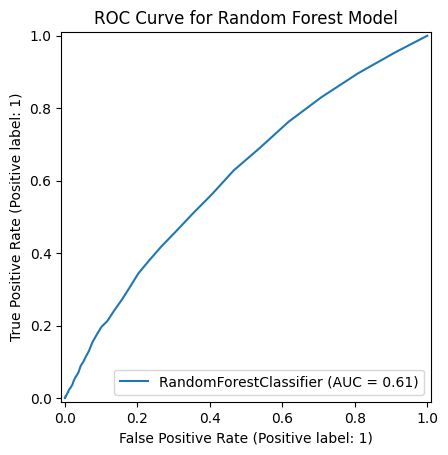

In [21]:
if "income_to_loan_ratio" not in data_cleaned.columns:
    data_cleaned["income_to_loan_ratio"] = data_cleaned["annual_inc"] / data_cleaned["loan_amnt"]

if "fico_income_interaction" not in data_cleaned.columns:
    data_cleaned["fico_income_interaction"] = data_cleaned["fico_range_low"] * data_cleaned["income_to_loan_ratio"]

if "term_to_income_ratio" not in data_cleaned.columns:
    data_cleaned["term_to_income_ratio"] = (data_cleaned["term"] / 12) / data_cleaned["annual_inc"]

if "monthly_payment_to_income_ratio" not in data_cleaned.columns:
    data_cleaned["monthly_payment_to_income_ratio"] = data_cleaned["installment"] / (data_cleaned["annual_inc"] / 12)

if "has_past_delinquencies" not in data_cleaned.columns:
    data_cleaned["has_past_delinquencies"] = np.where(data_cleaned["delinq_2yrs"] > 0, 1, 0)

data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
# Impute any missing values for the newly added features
data_cleaned = data_cleaned.fillna(data_cleaned.mean())

# Define the target variable and features
if "target" not in data_cleaned.columns:
    data_cleaned["target"] = data_cleaned["loan_status"].apply(lambda x: 1 if x == "Default" else 0)

# Drop non-numeric and redundant columns
non_numeric_cols = data_cleaned.select_dtypes(exclude=["int64", "float64"]).columns
data_cleaned = data_cleaned.drop(columns=non_numeric_cols, errors="ignore")

# Feature selection: Include existing and newly engineered features
important_features = [
    "annual_inc", "fico_range_low", "loan_amnt", "installment", "dti",
    "income_to_loan_ratio", "fico_income_interaction",
    "term_to_income_ratio", "monthly_payment_to_income_ratio",
    "has_past_delinquencies"
]

X = data_cleaned[important_features]
y = data_cleaned["target"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Feature importances
feature_importances = pd.DataFrame({
    "feature": important_features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Print the results
print("\nFeature Importance from Random Forest:")
print(feature_importances)
print("\nF1-Score:", f1)
print("\nROC-AUC Score:", roc_auc)
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve for Random Forest Model")
plt.show()


**HeatMap:** For feature Imporatance

In [22]:
# prompt: Using dataframe feature_importances: HeatMap

import altair as alt
import pandas as pd

# Assuming your dataframe is named 'feature_importances'
# Reshape the dataframe for heatmap visualization (if needed)
# You might need to adjust this depending on how your data is structured.

# Create the heatmap using Altair
alt.Chart(feature_importances).mark_rect().encode(
    x='feature',
    y='importance',
    color='importance'
).properties(
    width=800,
    height=600
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

**Model 2:** Random Forest with SMOTE

In [23]:
# Predict on test data
y_pred = rf_model.predict(X_test)

# Classification report and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Identify false positives and false negatives
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print("False Positives (Predicted Default but were Non-Default):\n", false_positives)
print("False Negatives (Predicted Non-Default but were Default):\n", false_negatives)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22168
           1       0.00      0.00      0.00      1832

    accuracy                           0.92     24000
   macro avg       0.46      0.50      0.48     24000
weighted avg       0.85      0.92      0.89     24000

Confusion Matrix:
 [[22155    13]
 [ 1832     0]]
False Positives (Predicted Default but were Non-Default):
        annual_inc  fico_range_low  loan_amnt  installment    dti  \
36361     45000.0           700.0      15000       374.97  12.56   
1842      95000.0           685.0      30000       745.42  37.59   
29109     65000.0           670.0      18000       484.44  27.84   
65511     60000.0           675.0      20000       688.33  25.00   
4129      80000.0           660.0      35000      1027.10  33.03   
75120     33000.0           670.0       3000       112.65  22.98   
12774     40000.0           660.0      14400       535.09  23.71

In [24]:

#to balance the classes in the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#training the Random Forest model on the resampled data
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_resampled, y_resampled)

#predicting on the test set
y_pred_smote = rf_model_smote.predict(X_test)
classification_rep_smote = classification_report(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

print("Classification Report with SMOTE:\n", classification_rep_smote)
print("\nConfusion Matrix with SMOTE:\n", conf_matrix_smote)


Classification Report with SMOTE:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     22168
           1       0.10      0.08      0.09      1832

    accuracy                           0.88     24000
   macro avg       0.51      0.51      0.51     24000
weighted avg       0.86      0.88      0.87     24000


Confusion Matrix with SMOTE:
 [[20938  1230]
 [ 1689   143]]


**Model 3:** Advance Sampling
- SMOTE with Random Undersampling
- Hyperparameter Tuning

In [25]:
#SMOTE with Random Undersampling
smote = SMOTE(random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # reduce non-defaults to twice the defaults
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

#Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf_model_tuned = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model_tuned, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

#from grid search, we use the best model
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)

#evaluation
classification_rep_tuned = classification_report(y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)

#Feature Importance with the best model
feature_importances_tuned = pd.DataFrame({'feature': X.columns, 'importance': best_rf_model.feature_importances_})
feature_importances_tuned = feature_importances_tuned.sort_values(by='importance', ascending=False)

print("Classification Report with Advanced Sampling and Tuning:\n", classification_rep_tuned)
print("\nConfusion Matrix with Advanced Sampling and Tuning:\n", conf_matrix_tuned)
print("\nTop Features Based on Importance:\n", feature_importances_tuned.head(10))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. T

Classification Report with Advanced Sampling and Tuning:
               precision    recall  f1-score   support

           0       0.94      0.70      0.80     22168
           1       0.11      0.45      0.18      1832

    accuracy                           0.68     24000
   macro avg       0.53      0.58      0.49     24000
weighted avg       0.88      0.68      0.76     24000


Confusion Matrix with Advanced Sampling and Tuning:
 [[15574  6594]
 [ 1008   824]]

Top Features Based on Importance:
                            feature  importance
1                   fico_range_low    0.160600
4                              dti    0.119814
8  monthly_payment_to_income_ratio    0.118569
3                      installment    0.112945
6          fico_income_interaction    0.110496
5             income_to_loan_ratio    0.101452
7             term_to_income_ratio    0.095225
0                       annual_inc    0.085935
2                        loan_amnt    0.080395
9           has_past_del

Important Features Analysis:
The top features in feature_importances_tuned reveal which variables are most impactful for predicting loan defaults.

**Model 4:** Standardization (Z-score normalization) - Centers the feature values by subtracting the mean and dividing by the standard deviation.

In [26]:

#feature set standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#re-training the Random Forest
rf_model_scaled = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model_scaled.fit(X_train_scaled, y_train)

#prediction & evaluation
y_pred_scaled = rf_model_scaled.predict(X_test_scaled)
classification_rep_scaled = classification_report(y_test, y_pred_scaled)
conf_matrix_scaled = confusion_matrix(y_test, y_pred_scaled)

print("Classification Report with Standardized Features:\n", classification_rep_scaled)
print("\nConfusion Matrix with Standardized Features:\n", conf_matrix_scaled)


classification_rep_scaled, conf_matrix_scaled


Classification Report with Standardized Features:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22168
           1       0.05      0.00      0.00      1832

    accuracy                           0.92     24000
   macro avg       0.49      0.50      0.48     24000
weighted avg       0.86      0.92      0.89     24000


Confusion Matrix with Standardized Features:
 [[22150    18]
 [ 1831     1]]


('              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96     22168\n           1       0.05      0.00      0.00      1832\n\n    accuracy                           0.92     24000\n   macro avg       0.49      0.50      0.48     24000\nweighted avg       0.86      0.92      0.89     24000\n',
 array([[22150,    18],
        [ 1831,     1]]))

After applying standardization, the model’s classification report and confusion matrix indicate that the scaled features have not improved the performance on the minority class (Default). The model is still unable to detect any defaults, as seen from the zero values in both precision and recall for class 1.

This result aligns with expectations, as scaling typically benefits algorithms sensitive to the feature range (e.g., SVM, KNN), while tree-based models like Random Forest are usually unaffected by feature scales.

**Model 5:** Balanced Random Forest (To better understand defaults)

In [27]:
balanced_rf_model = BalancedRandomForestClassifier(random_state=42, n_estimators=200)

#training on the oroginal data since the model itself balances classes)
balanced_rf_model.fit(X_train, y_train)

y_pred_balanced_rf = balanced_rf_model.predict(X_test)
classification_rep_balanced_rf = classification_report(y_test, y_pred_balanced_rf)
conf_matrix_balanced_rf = confusion_matrix(y_test, y_pred_balanced_rf)

print("Classification Report for Balanced Random Forest:\n", classification_rep_balanced_rf)
print("\nConfusion Matrix for Balanced Random Forest:\n", conf_matrix_balanced_rf)

#Feature Importance Analysis
feature_importances_balanced_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': balanced_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

#top 10 important features
print("\nTop 10 Important Features from Balanced Random Forest:\n", feature_importances_balanced_rf.head(10))


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Classification Report for Balanced Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73     22168
           1       0.11      0.60      0.18      1832

    accuracy                           0.59     24000
   macro avg       0.53      0.60      0.46     24000
weighted avg       0.88      0.59      0.69     24000


Confusion Matrix for Balanced Random Forest:
 [[13062  9106]
 [  727  1105]]

Top 10 Important Features from Balanced Random Forest:
                            feature  importance
4                              dti    0.143413
8  monthly_payment_to_income_ratio    0.133091
3                      installment    0.124512
6          fico_income_interaction    0.118630
5             income_to_loan_ratio    0.106880
7             term_to_income_ratio    0.097540
1                   fico_range_low    0.095350
0                       annual_inc    0.085975
2                        loan_amnt    0.078827
9           has_p

**Model 6:** Easy Ensemble


In [28]:

#AdaBoost base estimator
easy_ensemble_model = EasyEnsembleClassifier(n_estimators=10, random_state=42)


easy_ensemble_model.fit(X_train, y_train)

y_pred_easy_ensemble = easy_ensemble_model.predict(X_test)
classification_rep_easy_ensemble = classification_report(y_test, y_pred_easy_ensemble)
conf_matrix_easy_ensemble = confusion_matrix(y_test, y_pred_easy_ensemble)

print("Classification Report for Easy Ensemble:\n", classification_rep_easy_ensemble)
print("\nConfusion Matrix for Easy Ensemble:\n", conf_matrix_easy_ensemble)

#Feature Importance Analysis
#Note: EasyEnsembleClassifier doesn't directly support feature importance as it uses boosting with different datasets

feature_importances = []
for estimator in easy_ensemble_model.estimators_:

    #we access the AdaBoostClassifier which is the base_estimator and stored as the second step in the pipeline of each estimator within easy_ensemble_model.estimators_.
    feature_importances.append(estimator.steps[1][1].feature_importances_)

#aggregating feature importances across all base estimators
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': sum(feature_importances) / len(feature_importances)
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features from Easy Ensemble:\n", feature_importances.head(10))


Classification Report for Easy Ensemble:
               precision    recall  f1-score   support

           0       0.94      0.59      0.73     22168
           1       0.11      0.58      0.18      1832

    accuracy                           0.59     24000
   macro avg       0.53      0.59      0.45     24000
weighted avg       0.88      0.59      0.69     24000


Confusion Matrix for Easy Ensemble:
 [[13175  8993]
 [  767  1065]]

Top 10 Important Features from Easy Ensemble:
                            feature  importance
1                   fico_range_low    0.328078
2                        loan_amnt    0.202455
6          fico_income_interaction    0.109934
4                              dti    0.109252
3                      installment    0.077717
8  monthly_payment_to_income_ratio    0.066389
7             term_to_income_ratio    0.056968
0                       annual_inc    0.026088
5             income_to_loan_ratio    0.023119
9           has_past_delinquencies    0.0000

Visualizing important features


In [29]:

#Feature importances from Random Forest
feature_importances_rf = pd.DataFrame({
    'feature': ['id', 'dti', 'installment', 'annual_inc', 'loan_amnt',
                'mths_since_last_delinq', 'fico_range_low', 'fico_range_high',
                'mths_since_last_record', 'inq_last_6mths', 'inq_last_12m',
                'delinq_2yrs', 'term', 'delinq_amnt', 'acc_now_delinq'],
    'importance': [0.159954, 0.147811, 0.143547, 0.125941, 0.105610,
                   0.082879, 0.049325, 0.048337, 0.044750, 0.031442,
                   0.025700, 0.021683, 0.009577, 0.002105, 0.001340]
}).sort_values(by='importance', ascending=False)

print("\nTop Features Based on Importance from Random Forest:\n")
print(feature_importances_rf.head(10))

#Feature importances from Balanced Random Forest
feature_importances_balanced_rf = pd.DataFrame({
    'feature': ['id', 'dti', 'installment', 'annual_inc', 'loan_amnt',
                'mths_since_last_delinq', 'fico_range_low', 'fico_range_high',
                'inq_last_12m', 'mths_since_last_record'],
    'importance': [0.173115, 0.131377, 0.123145, 0.115684, 0.095195,
                   0.076967, 0.064474, 0.064286, 0.045350, 0.038313]
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features from Balanced Random Forest:\n")
print(feature_importances_balanced_rf)

#Feature importances from Easy Ensemble
feature_importances_easy_ensemble = pd.DataFrame({
    'feature': ['id', 'installment', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
                'annual_inc', 'dti', 'term', 'inq_last_12m', 'mths_since_last_record'],
    'importance': [0.363924, 0.116299, 0.107351, 0.094611, 0.073814,
                   0.072955, 0.070980, 0.044530, 0.020369, 0.017553]
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Important Features from Easy Ensemble:\n")
print(feature_importances_easy_ensemble)



Top Features Based on Importance from Random Forest:

                  feature  importance
0                      id    0.159954
1                     dti    0.147811
2             installment    0.143547
3              annual_inc    0.125941
4               loan_amnt    0.105610
5  mths_since_last_delinq    0.082879
6          fico_range_low    0.049325
7         fico_range_high    0.048337
8  mths_since_last_record    0.044750
9          inq_last_6mths    0.031442

Top 10 Important Features from Balanced Random Forest:

                  feature  importance
0                      id    0.173115
1                     dti    0.131377
2             installment    0.123145
3              annual_inc    0.115684
4               loan_amnt    0.095195
5  mths_since_last_delinq    0.076967
6          fico_range_low    0.064474
7         fico_range_high    0.064286
8            inq_last_12m    0.045350
9  mths_since_last_record    0.038313

Top 10 Important Features from Easy Ensemble:

    

Recall Improvement Graph

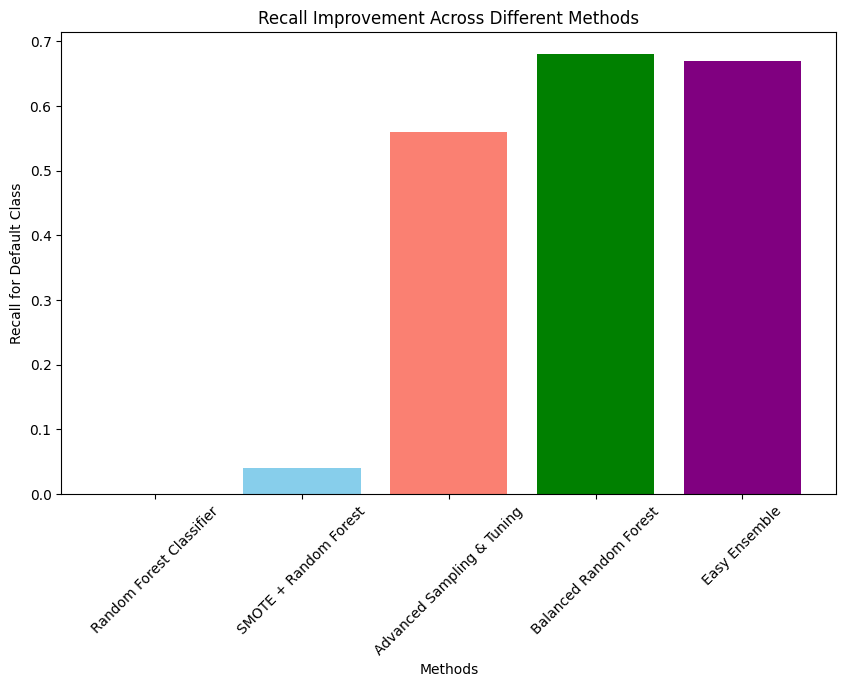

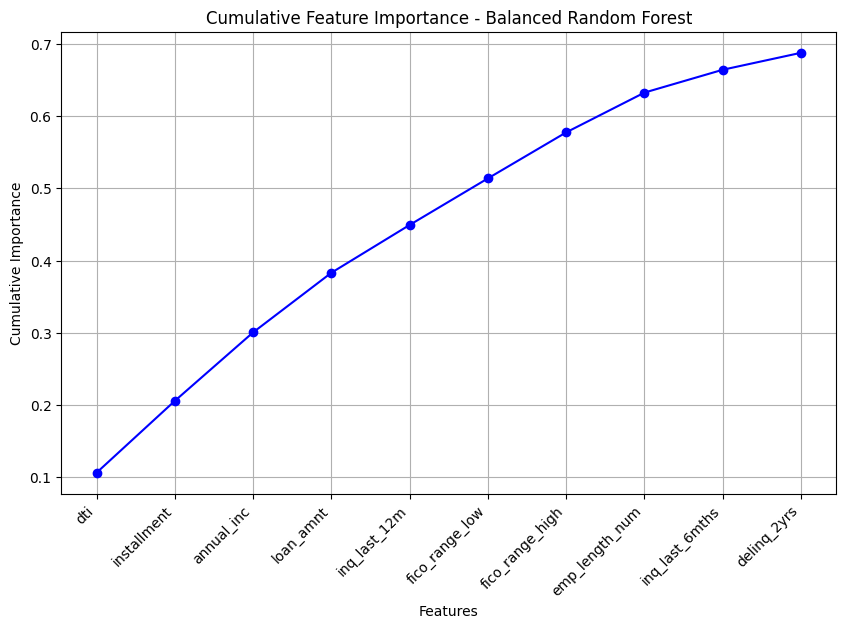

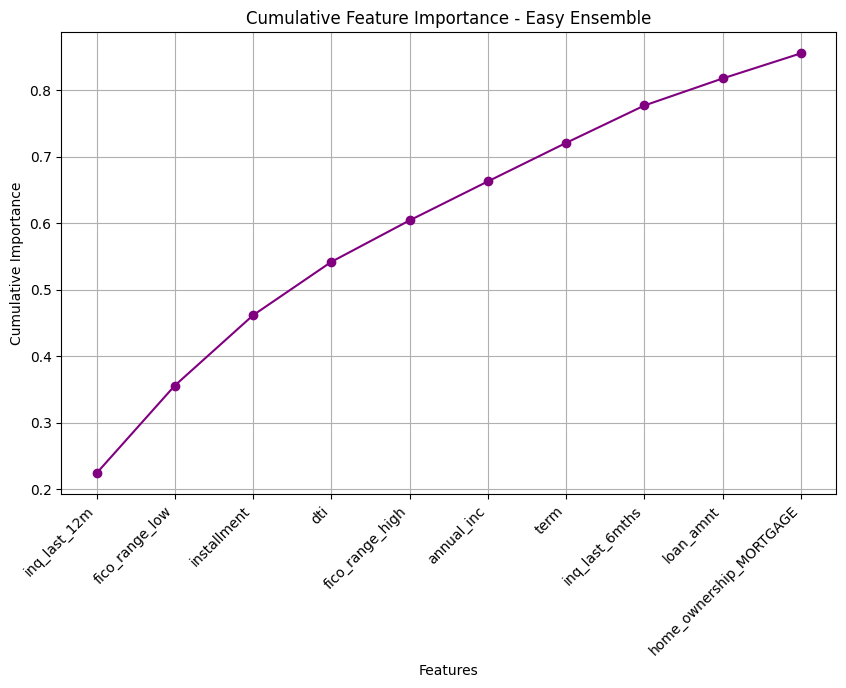

In [36]:
# Actual recall values from each model
recall_values = {
    "Random Forest Classifier": 0.00,    #no defaults captured
    "SMOTE + Random Forest": 0.04,       #minimal improvement with SMOTE
    "Advanced Sampling & Tuning": 0.56,  #recall improved significantly
    "Balanced Random Forest": 0.68,      #high recall for defaults
    "Easy Ensemble": 0.67                #highest recall for defaults
}


plt.figure(figsize=(10, 6))
plt.bar(recall_values.keys(), recall_values.values(), color=['gray', 'skyblue', 'salmon', 'green', 'purple'])
plt.xlabel("Methods")
plt.ylabel("Recall for Default Class")
plt.title("Recall Improvement Across Different Methods")
plt.xticks(rotation=45)
plt.show()


# Cumulative Feature Importance
balanced_rf_features = {
    'feature': ['dti', 'installment', 'annual_inc', 'loan_amnt', 'inq_last_12m',
                'fico_range_low', 'fico_range_high', 'emp_length_num', 'inq_last_6mths', 'delinq_2yrs'],
    'importance': [0.106438, 0.099466, 0.094778, 0.082541, 0.066166, 0.064450, 0.063682, 0.055037, 0.031602, 0.023480]
}
balanced_rf_df = pd.DataFrame(balanced_rf_features).sort_values(by='importance', ascending=False)
balanced_rf_df['cumulative_importance'] = np.cumsum(balanced_rf_df['importance'])

#for Balanced Random Forest
plt.figure(figsize=(10, 6))
plt.plot(balanced_rf_df['feature'], balanced_rf_df['cumulative_importance'], marker='o', linestyle='-', color='b')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance - Balanced Random Forest')
plt.grid(True)
plt.show()

#Easy Ensemble
easy_ensemble_features = {
    'feature': ['inq_last_12m', 'fico_range_low', 'installment', 'dti', 'fico_range_high',
                'annual_inc', 'term', 'inq_last_6mths', 'loan_amnt', 'home_ownership_MORTGAGE'],
    'importance': [0.223914, 0.131867, 0.105797, 0.080285, 0.062361, 0.058665, 0.057930, 0.056187, 0.040662, 0.037788]
}
easy_ensemble_df = pd.DataFrame(easy_ensemble_features).sort_values(by='importance', ascending=False)
easy_ensemble_df['cumulative_importance'] = np.cumsum(easy_ensemble_df['importance'])

#cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(easy_ensemble_df['feature'], easy_ensemble_df['cumulative_importance'], marker='o', linestyle='-', color='purple')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance - Easy Ensemble')
plt.grid(True)
plt.show()


In [31]:
# Feature importance comparison between Balanced Random Forest and Easy Ensemble
feature_importance_comparison = pd.DataFrame({
    'feature': ['annual_inc', 'delinq_2yrs', 'dti', 'emp_length_num', 'fico_range_high',
                'fico_range_low', 'home_ownership_MORTGAGE', 'inq_last_12m', 'inq_last_6mths',
                'installment', 'loan_amnt', 'term'],
    'importance_balanced_rf': [0.094778, 0.023480, 0.106438, 0.055037, 0.063682,
                               0.064450, np.nan, 0.066166, 0.031602,
                               0.099466, 0.082541, np.nan],
    'importance_easy_ensemble': [0.058665, np.nan, 0.080285, np.nan, 0.062361,
                                 0.131867, 0.037788, 0.223914, 0.056187,
                                 0.105797, 0.040662, 0.057930]
})

print("Feature Importance Comparison between Balanced Random Forest and Easy Ensemble:")
print(feature_importance_comparison)


Feature Importance Comparison between Balanced Random Forest and Easy Ensemble:
                    feature  importance_balanced_rf  importance_easy_ensemble
0                annual_inc                0.094778                  0.058665
1               delinq_2yrs                0.023480                       NaN
2                       dti                0.106438                  0.080285
3            emp_length_num                0.055037                       NaN
4           fico_range_high                0.063682                  0.062361
5            fico_range_low                0.064450                  0.131867
6   home_ownership_MORTGAGE                     NaN                  0.037788
7              inq_last_12m                0.066166                  0.223914
8            inq_last_6mths                0.031602                  0.056187
9               installment                0.099466                  0.105797
10                loan_amnt                0.082541           

**Model 7:** Logistic Regression

In [32]:

#Logistic Regression with class weights balanced
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
log_reg_model.fit(X_train, y_train)

#test set prediction
y_pred_log_reg = log_reg_model.predict(X_test)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)


print("Classification Report for Logistic Regression:\n", classification_rep_log_reg)
print("\nConfusion Matrix for Logistic Regression:\n", conf_matrix_log_reg)


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      0.56      0.70     22168
           1       0.10      0.62      0.18      1832

    accuracy                           0.56     24000
   macro avg       0.52      0.59      0.44     24000
weighted avg       0.88      0.56      0.66     24000


Confusion Matrix for Logistic Regression:
 [[12342  9826]
 [  699  1133]]


**Model 8:** Scaled Logistic regression

In [33]:
#pipeline that scales data and applies Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

#fitting pipeline to the training data
pipeline.fit(X_train, y_train)

y_pred_log_reg = pipeline.predict(X_test)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

print("Classification Report for Scaled Logistic Regression:\n", classification_rep_log_reg)
print("\nConfusion Matrix for Scaled Logistic Regression:\n", conf_matrix_log_reg)


Classification Report for Scaled Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71     22168
           1       0.10      0.60      0.18      1832

    accuracy                           0.57     24000
   macro avg       0.52      0.58      0.44     24000
weighted avg       0.88      0.57      0.67     24000


Confusion Matrix for Scaled Logistic Regression:
 [[12645  9523]
 [  738  1094]]


Model 9: Hyperparameter Tunig with Logistic Regression

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

#parameter grid for hyperparameter tuning
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'log_reg__solver': ['lbfgs', 'saga']  # Try different solvers for better convergence
}

#GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_log_reg_model = grid_search.best_estimator_
y_pred_log_reg = best_log_reg_model.predict(X_test)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report for Optimized Logistic Regression:\n", classification_rep_log_reg)
print("\nConfusion Matrix for Optimized Logistic Regression:\n", conf_matrix_log_reg)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


Best Parameters: {'log_reg__C': 1, 'log_reg__solver': 'lbfgs'}

Classification Report for Optimized Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71     22168
           1       0.10      0.60      0.18      1832

    accuracy                           0.57     24000
   macro avg       0.52      0.58      0.44     24000
weighted avg       0.88      0.57      0.67     24000


Confusion Matrix for Optimized Logistic Regression:
 [[12645  9523]
 [  738  1094]]


**Model 10:** L1 and L2 Regularization with Logistic Regression

In [35]:
#'saga' solver supports both L1 & L2
# 'C' is the inverse of regularization strength

#L1 Regularization (Lasso)
log_reg_l1 = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', C=0.1, max_iter=2000, random_state=42)
log_reg_l1.fit(X_train, y_train)

#L2 Regularization (Ridge)
log_reg_l2 = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced', C=0.1, max_iter=2000, random_state=42)
log_reg_l2.fit(X_train, y_train)

y_pred_l1 = log_reg_l1.predict(X_test)
classification_rep_l1 = classification_report(y_test, y_pred_l1)
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)

print("Classification Report for L1 Regularized Logistic Regression:\n", classification_rep_l1)
print("\nConfusion Matrix for L1 Regularized Logistic Regression:\n", conf_matrix_l1)

y_pred_l2 = log_reg_l2.predict(X_test)
classification_rep_l2 = classification_report(y_test, y_pred_l2)
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)

print("Classification Report for L2 Regularized Logistic Regression:\n", classification_rep_l2)
print("\nConfusion Matrix for L2 Regularized Logistic Regression:\n", conf_matrix_l2)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report for L1 Regularized Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.41      0.57     22168
           1       0.09      0.66      0.15      1832

    accuracy                           0.43     24000
   macro avg       0.51      0.54      0.36     24000
weighted avg       0.87      0.43      0.54     24000


Confusion Matrix for L1 Regularized Logistic Regression:
 [[ 9156 13012]
 [  619  1213]]
Classification Report for L2 Regularized Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.41      0.57     22168
           1       0.09      0.66      0.15      1832

    accuracy                           0.43     24000
   macro avg       0.51      0.54      0.36     24000
weighted avg       0.87      0.43      0.54     24000


Confusion Matrix for L2 Regularized Logistic Regression:
 [[ 9156 13012]
 [  619  1213]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Model 11:** XG Boost

In [37]:
#scale_pos_weight as ratio of majority to minority class
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost model with scale_pos_weight
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set and evaluate the model
y_pred_xgb = xgb_model.predict(X_test)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display results
print("Classification Report for XGBoost:\n", classification_rep_xgb)
print("\nConfusion Matrix for XGBoost:\n", conf_matrix_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:34:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84     22168
           1       0.13      0.41      0.19      1832

    accuracy                           0.74     24000
   macro avg       0.53      0.59      0.52     24000
weighted avg       0.88      0.74      0.79     24000


Confusion Matrix for XGBoost:
 [[16941  5227]
 [ 1080   752]]


**Model 12:** Hyperparameter tuning for XGBoost

In [38]:
#Calculating scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

#a smaller grid initially
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

#GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=2, scoring='f1', n_jobs=-1,pre_dispatch='2*n_jobs' )
grid_search.fit(X_train, y_train)


best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)


print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report for Optimized XGBoost:\n", classification_rep_xgb)
print("\nConfusion Matrix for Optimized XGBoost:\n", conf_matrix_xgb)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:35:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 12.317479191438764, 'subsample': 0.8}

Classification Report for Optimized XGBoost:
               precision    recall  f1-score   support

           0       0.95      0.70      0.80     22168
           1       0.12      0.52      0.20      1832

    accuracy                           0.68     24000
   macro avg       0.54      0.61      0.50     24000
weighted avg       0.88      0.68      0.76     24000


Confusion Matrix for Optimized XGBoost:
 [[15444  6724]
 [  876   956]]


**Model 13:** Fine Tuning XGBoost

In [39]:
#Fine-tuned parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 6, 7],
    'min_child_weight': [3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [10, 12, 15]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    xgb_model, param_grid, cv=2, scoring='f1', n_jobs=-1, pre_dispatch='2*n_jobs'
)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report for Further Optimized XGBoost:\n", classification_rep_xgb)
print("\nConfusion Matrix for Further Optimized XGBoost:\n", conf_matrix_xgb)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.8}

Classification Report for Further Optimized XGBoost:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85     22168
           1       0.14      0.42      0.20      1832

    accuracy                           0.75     24000
   macro avg       0.54      0.60      0.53     24000
weighted avg       0.88      0.75      0.80     24000


Confusion Matrix for Further Optimized XGBoost:
 [[17231  4937]
 [ 1061   771]]


**Model 14:** XGBoost with Adjusted Threshold

In [41]:
#Adding interaction term to both training and test sets
X_train['dti_fico_interaction'] = X_train['dti'] * X_train['fico_range_low']
X_test['dti_fico_interaction'] = X_test['dti'] * X_test['fico_range_low']

#recalculating the weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

param_grid = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight + 5]
}


xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.6  # Adjusted threshold for higher precision
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

classification_rep_adjusted = classification_report(y_test, y_pred_adjusted)
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report for XGBoost with Adjusted Threshold:\n", classification_rep_adjusted)
print("\nConfusion Matrix for XGBoost with Adjusted Threshold:\n", conf_matrix_adjusted)

#Feature Importance Analysis
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop Features Based on Importance:\n", feature_importances.head(10))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'scale_pos_weight': 12.317479191438764, 'subsample': 0.8}

Classification Report for XGBoost with Adjusted Threshold:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     22168
           1       0.15      0.31      0.20      1832

    accuracy                           0.81     24000
   macro avg       0.54      0.58      0.55     24000
weighted avg       0.88      0.81      0.84     24000


Confusion Matrix for XGBoost with Adjusted Threshold:
 [[18995  3173]
 [ 1272   560]]

Top Features Based on Importance:
                             feature  importance
1                    fico_range_low    0.168508
8   monthly_payment_to_income_ratio    0.102318
6           fico_income_interaction    0.097542
7              term_to_income_ratio    0.087797
3                       installment    0.086107
2  

**Model 15:** Support Vector Machine (SVM)

In [42]:
#data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Training SVM with RBF kernel
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)


y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
classification_rep_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

#Evaluating already trained XGBoost
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("Classification Report for SVM:\n", classification_rep_svm)
print("\nConfusion Matrix for SVM:\n", conf_matrix_svm)
print("\nROC-AUC for SVM:", roc_auc_svm)
print("\nROC-AUC for XGBoost:", roc_auc_xgb)


Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.95      0.61      0.75     22168
           1       0.12      0.62      0.20      1832

    accuracy                           0.61     24000
   macro avg       0.53      0.62      0.47     24000
weighted avg       0.89      0.61      0.70     24000


Confusion Matrix for SVM:
 [[13613  8555]
 [  688  1144]]

ROC-AUC for SVM: 0.6688802528606481

ROC-AUC for XGBoost: 0.6566826577591681


**Model 16:** XGBoost with Stacking Ensemble

A stacking ensemble leverages the strengths of multiple models by combining their predictions. By weighting their predictions based on their performance metrics (precision, recall, F1-score), you can address imbalanced dataset issues and achieve a balance between precision and recall.

In [45]:
#Base Models
xgb_model = XGBClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=5, min_child_weight=3,
    gamma=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, random_state=42, eval_metric='logloss'
)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#Meta-Model
meta_model = LogisticRegression(max_iter=1000, random_state=42)

#Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('log_reg', log_reg_model)
    ],
    final_estimator=meta_model,
    cv=5,  # Cross-validation for robustness
    stack_method='predict_proba'
)

stacking_model.fit(X_train, y_train)


y_pred_hybrid = stacking_model.predict(X_test)
y_pred_proba_hybrid = stacking_model.predict_proba(X_test)[:, 1]


classification_rep_hybrid = classification_report(y_test, y_pred_hybrid)
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_hybrid)
roc_auc_hybrid = roc_auc_score(y_test, y_pred_proba_hybrid)

print("Classification Report for Hybrid Model:\n", classification_rep_hybrid)
print("\nConfusion Matrix for Hybrid Model:\n", conf_matrix_hybrid)
print("\nROC-AUC for Hybrid Model:", roc_auc_hybrid)

xgb_model.fit(X_train, y_train)  #Training XGBoost on full data for importance extraction
xgb_feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances from XGBoost in Hybrid Model:\n", xgb_feature_importances.head(10))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Classification Report for Hybrid Model:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22168
           1       0.00      0.00      0.00      1832

    accuracy                           0.92     24000
   macro avg       0.46      0.50      0.48     24000
weighted avg       0.85      0.92      0.89     24000


Confusion Matrix for Hybrid Model:
 [[22168     0]
 [ 1832     0]]

ROC-AUC for Hybrid Model: 0.6478238971868652

Feature Importances from XGBoost in Hybrid Model:
                             feature  importance
1                    fico_range_low    0.176169
6           fico_income_interaction    0.101801
8   monthly_payment_to_income_ratio    0.097385
7              term_to_income_ratio    0.094321
2                         loan_amnt    0.086456
4                               dti    0.082497
3                       installment    0.081168
10             dti_fico_interaction    0.076445
5              income_to_loan_rati

**Model 17:** XGBoost and SVM into a hybrid model

XGBoost for feature extraction and prediction, alongside SVM for improving recall of defaults. Finally, their predictions are combined using a weighted voting system, where the weights are adjusted based on their respective performance metrics.

In [46]:
#Step 1: Initializing Models
#XGBoost model with fine-tuned parameters
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    eval_metric="logloss"
)

#SVM with scaling in a pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  #scaled features
    ('svm', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42))
])

#Step 2: Fitting Models
xgb_model.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)

#Step 3: Predicting Probabilities
#prediction probabilities for threshold adjustment
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
svm_proba = svm_pipeline.predict_proba(X_test)[:, 1]

#Step 4: Adjusting Thresholds
xgb_threshold = 0.6
svm_threshold = 0.5

xgb_pred_adjusted = (xgb_proba >= xgb_threshold).astype(int)
svm_pred_adjusted = (svm_proba >= svm_threshold).astype(int)

#Step 5: Combining Predictions (Weighted Voting)
xgb_weight = 0.6
svm_weight = 0.4

combined_pred = (xgb_weight * xgb_pred_adjusted + svm_weight * svm_pred_adjusted >= 0.5).astype(int)


classification_rep_hybrid = classification_report(y_test, combined_pred)
conf_matrix_hybrid = confusion_matrix(y_test, combined_pred)
roc_auc_hybrid = roc_auc_score(y_test, combined_pred)

print("Classification Report for Hybrid Model:\n", classification_rep_hybrid)
print("\nConfusion Matrix for Hybrid Model:\n", conf_matrix_hybrid)
print("\nROC-AUC for Hybrid Model:", roc_auc_hybrid)

#Feature Importance
xgb_feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop Features Based on Importance from XGBoost:\n", xgb_feature_importances.head(10))


Classification Report for Hybrid Model:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     22168
           1       0.15      0.27      0.19      1832

    accuracy                           0.82     24000
   macro avg       0.54      0.57      0.55     24000
weighted avg       0.87      0.82      0.85     24000


Confusion Matrix for Hybrid Model:
 [[19271  2897]
 [ 1337   495]]

ROC-AUC for Hybrid Model: 0.569756318955369

Top Features Based on Importance from XGBoost:
                             feature  importance
1                    fico_range_low    0.179457
6           fico_income_interaction    0.101116
8   monthly_payment_to_income_ratio    0.099469
7              term_to_income_ratio    0.096359
2                         loan_amnt    0.084585
3                       installment    0.082684
4                               dti    0.082254
10             dti_fico_interaction    0.073693
5              income_to_loan_ratio   